In [1]:
library(ggplot2)
library(coda)
library(knitr)
library(rjags)

Warning message:
“package ‘coda’ was built under R version 4.3.2”
Warning message:
“package ‘rjags’ was built under R version 4.3.2”
Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



### Exercise 1

Given the following un-normalized posterior distribution:

$$
g(\theta \mid x) \propto \frac{1}{2} \exp \left( -\frac{(\theta + 3)^2}{2} \right) + \frac{1}{2} \exp \left( -\frac{(\theta - 3)^2}{2} \right)
$$

a) Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm
b) Use a Norm(0,1) as random-walk candidate density
c) Plot the sampled distribution

The un-normalized posterior distribution is a mixture of two normal distributions: one centered in -3 and one in +3,
each with equal weight(1/2 and 1/2) and variance of 1:

$$
f(\theta \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(\theta - \mu)^2}{2\sigma^2} \right)
$$

To sample from a pdf we need to:
- Start with a value $\theta$
- Propose a new $\theta '$ from a proposal distribution $Q(s \mid \theta)$
- Decide whether to accept or not the new candidate sample on the basis of the Metropolis ratio: $\rho = \frac{f(s)}{f(\theta_t)} \frac{Q(\theta_t \mid s)}{Q(s \mid \theta_t)}$

If $\rho \geq 1$, the new candidate is accepted and $\theta_{t+1} = s$.

If $\rho < 1$, we only accept it with probability $\rho$:

Draw $u \sim U(0, 1)$ and set $\theta_{t+1} = s$ only if $u \leq \rho$.

If s is not accepted, we set $\theta_{t+1} = \theta_t$, i.e., the existing sample in the chain is repeated.

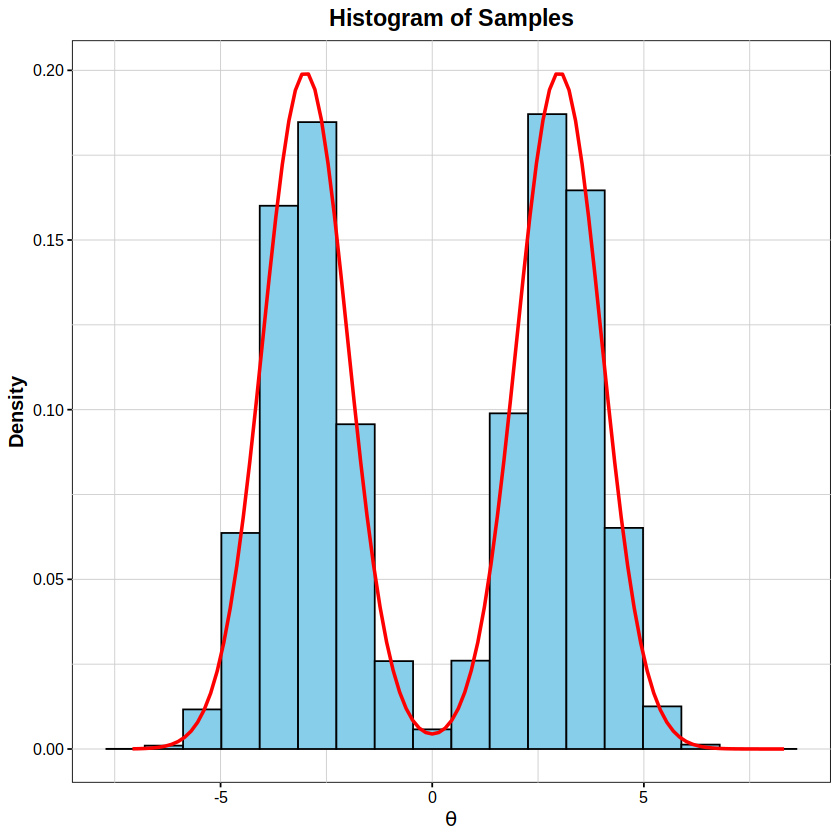

In [2]:
g = function(theta) {
    exp(-((theta + 3)^2)/2)/2 + exp(-((theta -3)^2)/2)/2 #unnormalized posterior distribution
}

Q = function(theta) {
    rnorm(1,theta,1) #proposal distribution (Norm(0,1))
}

n = 100000
start = 0

metropolis_hastings = function(start, n) {
    theta = numeric(n) #empty vector to store thetas values
    theta[1] = start #first value of the vector is the start and it is equal to zero
    for (i in 2:n) { #so we do a loop starting with the second value
        s = Q(theta[i-1]) #starting from the start and then proceeding 
        rho = (g(s) * dnorm(theta[i-1], s, 1)) / (g(theta[i-1]) * dnorm(s, theta[i-1], 1)) #calculate the acceptance ratio
        if (rho >= runif(1)) { #conditions on rho
            theta[i] = s
        } else {
            theta[i] = theta[i-1]
        }
    }
    return(theta)
}

samples = metropolis_hastings(start, n)
samples_df = data.frame(samples=samples)

bins_sturges = ceiling(log2(n) + 1)

ggplot(samples_df, aes(x=samples)) +
    geom_histogram(aes(y=after_stat(density)), bins=bins_sturges, fill="skyblue", color="black") + 
    stat_function(fun=function(x) 0.5*dnorm(x, mean =-3, sd=1) + 0.5*dnorm(x, mean=3, sd=1), color="red", linewidth= 1) + 
    labs(x=expression(theta), 
         y="Density", 
         title="Histogram of Samples") + 
    theme(
        text = element_text(size=12),
        axis.title.x = element_text(face="bold", size=12),
        axis.title.y = element_text(face="bold", size=12),
        axis.text = element_text(color="black"),
        axis.ticks = element_line(color="black"),
        plot.title = element_text(hjust=0.5, face="bold", size=14),
        panel.background = element_rect(fill = "white", color = "black"),
        panel.grid.major = element_line(linewidth=0.25, linetype='solid', color="grey80"),
        panel.grid.minor = element_line(linewidth=0.25, linetype='solid', color="grey80"))

b) Analyze the chain with the CODA package and plot the chain autocorrelation


Iterations = 1:1e+05
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
       0.03780        3.16585        0.01001        0.16882 

2. Quantiles for each variable:

   2.5%     25%     50%     75%   97.5% 
-4.6322 -2.9898  0.7363  3.0291  4.6601 


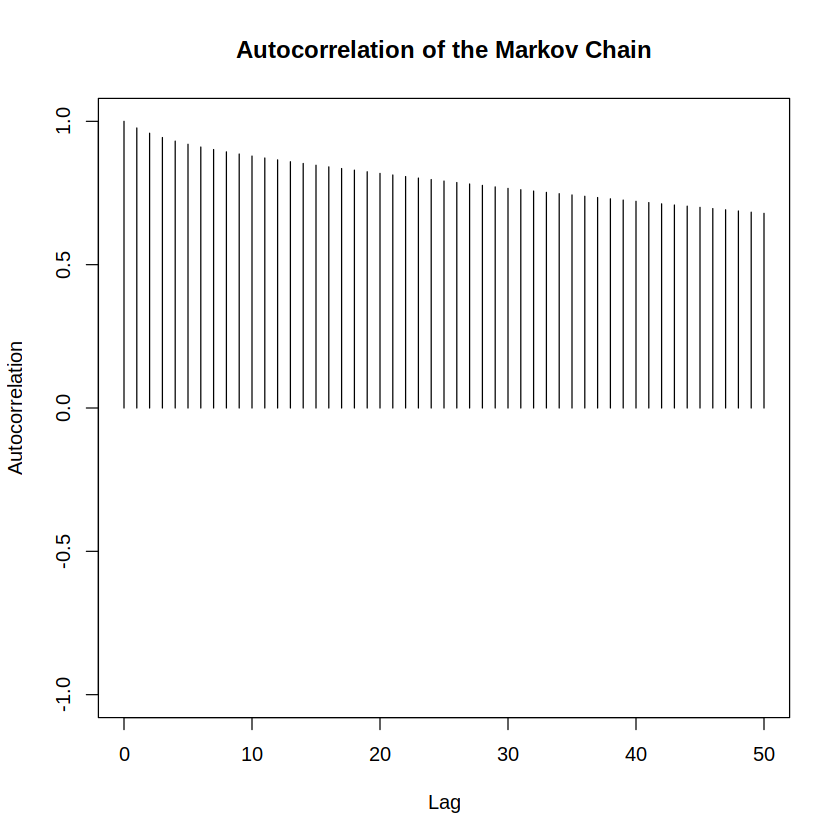

In [3]:
#autocorrelation gives me the correlation of the chain values with their past values. A high autocorrelation means high dependency on past
#values. 
mcmc_data = mcmc(samples) #converts samples in mcmc object required by coda
summary(mcmc_data)
autocorr.plot(mcmc_data, main="Autocorrelation of the Markov Chain")

c) Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and try the chain autocorrelation function. What are the best parameters?

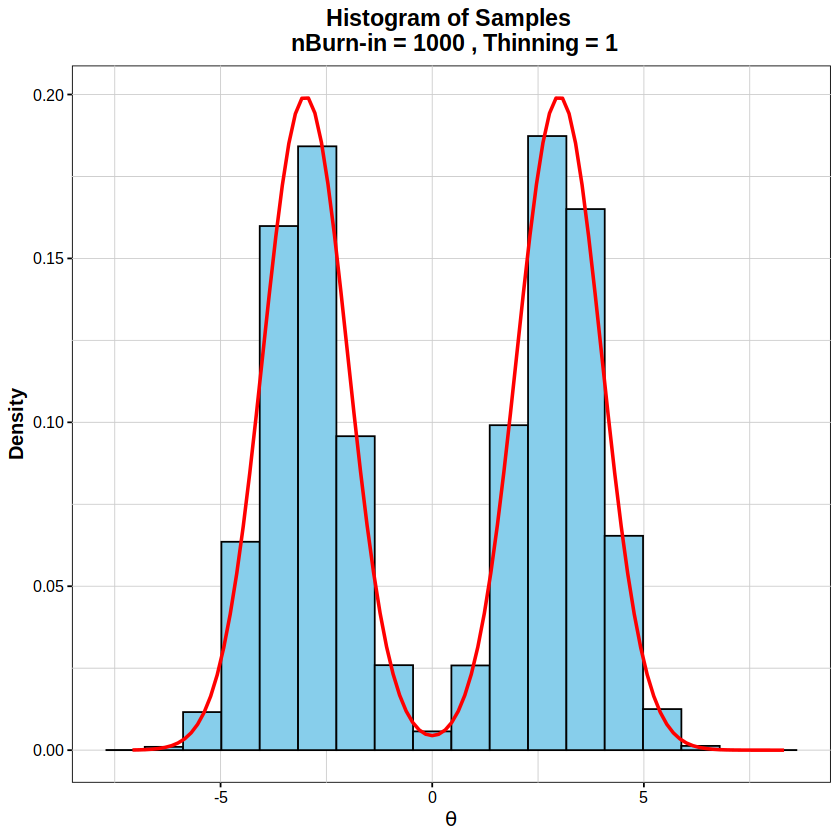

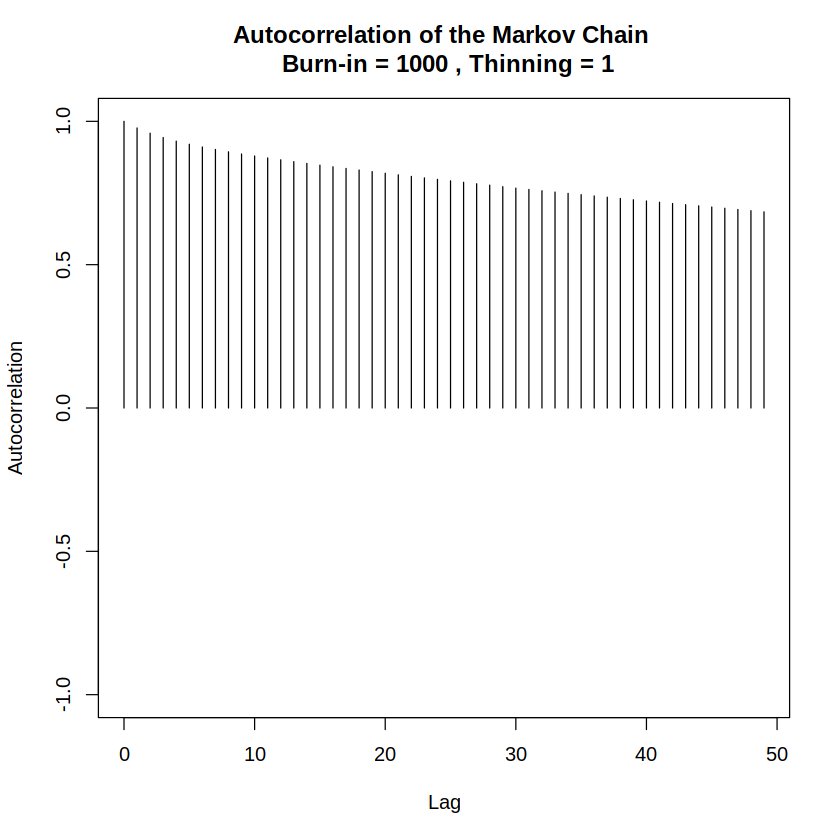

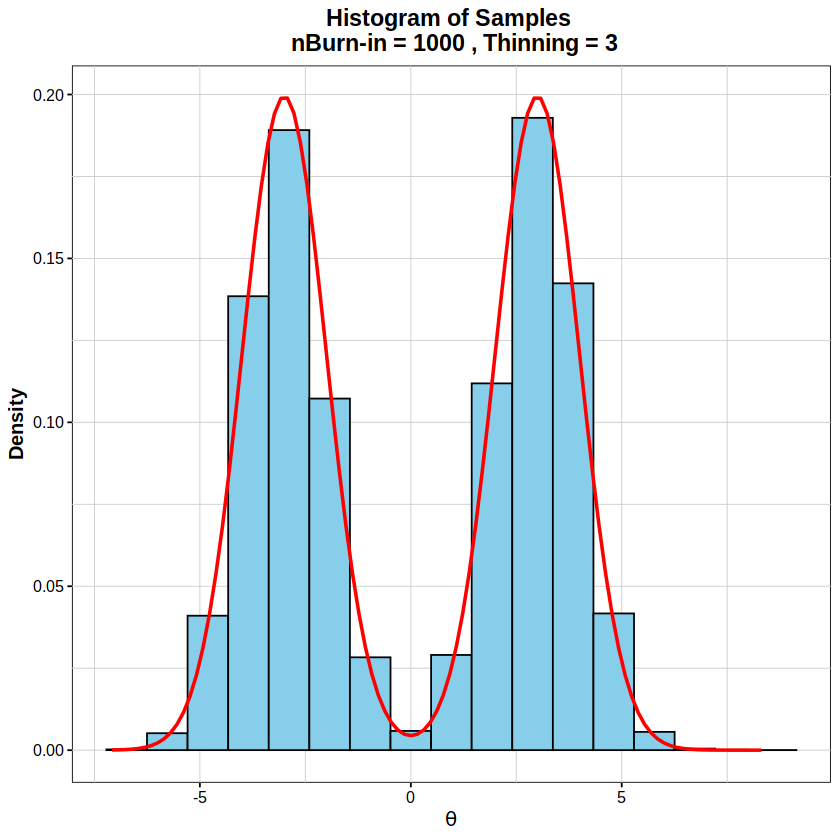

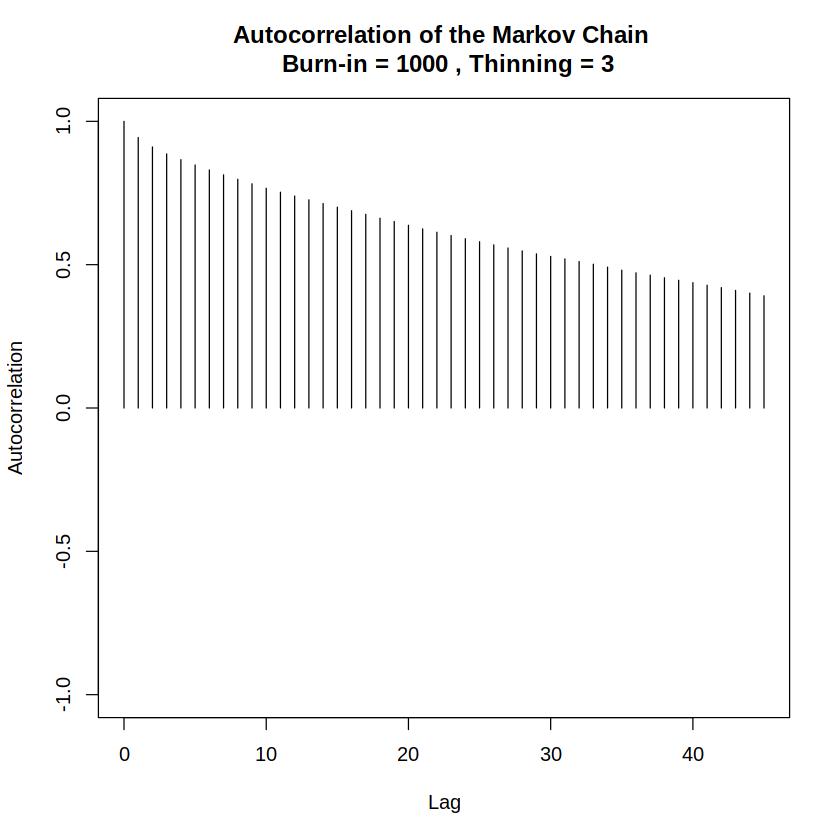

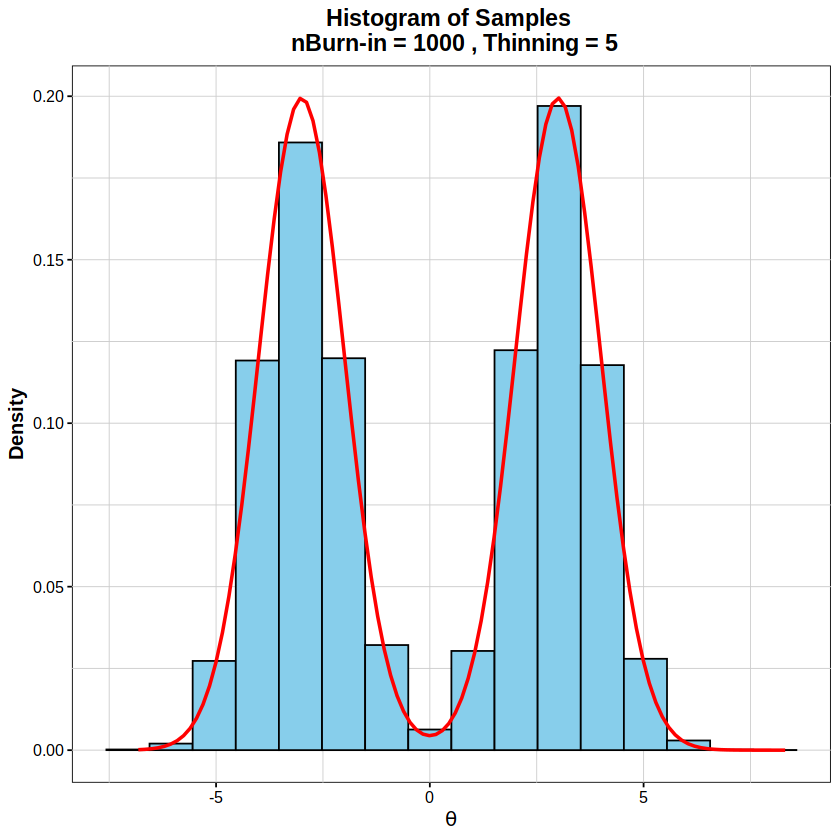

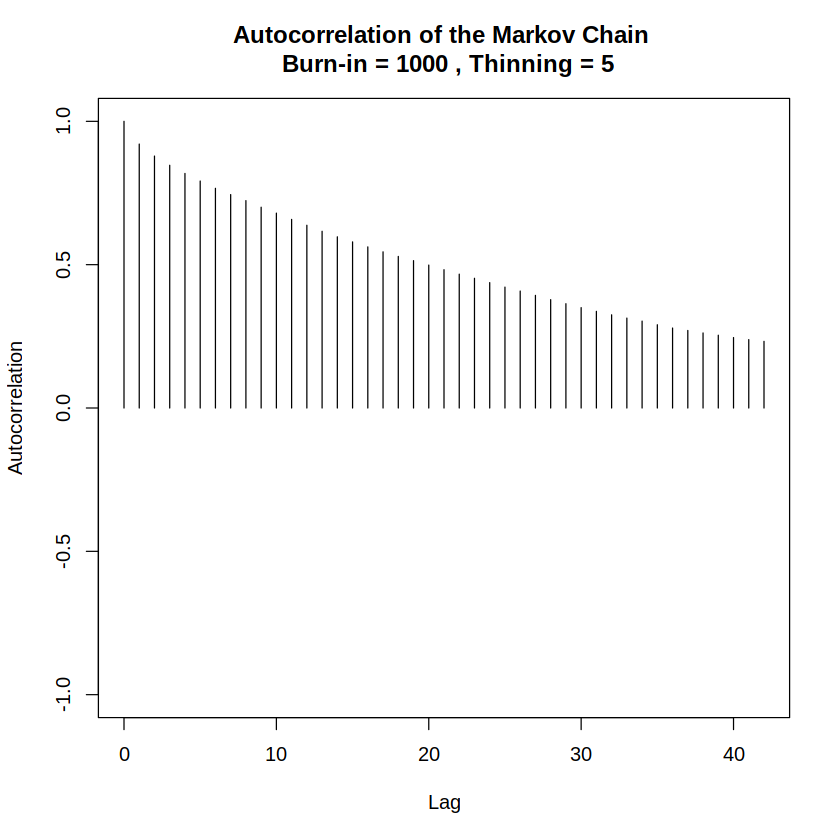

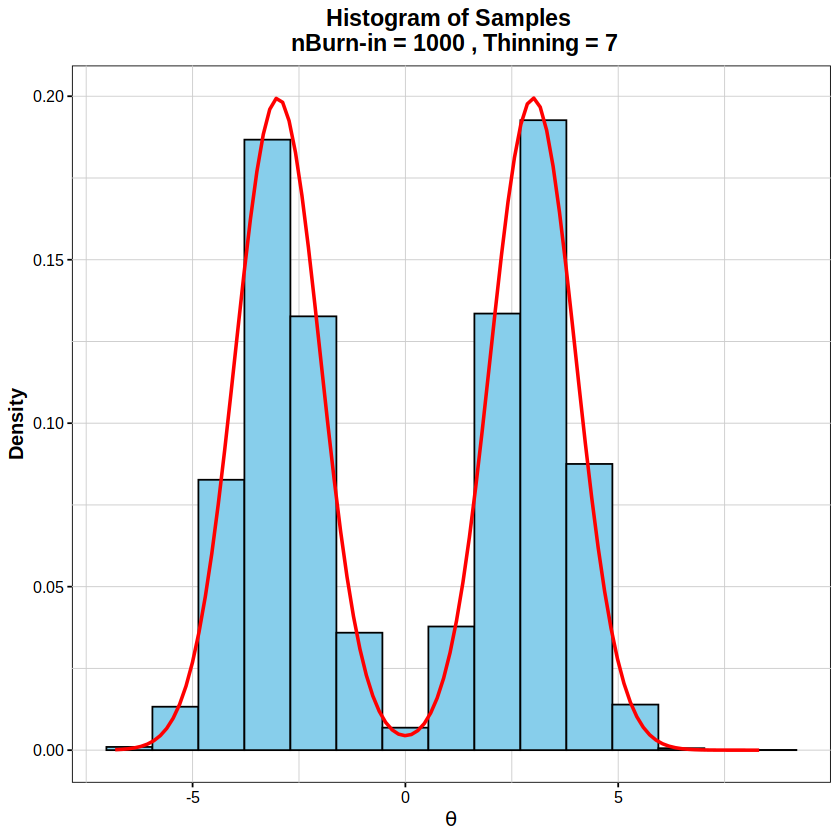

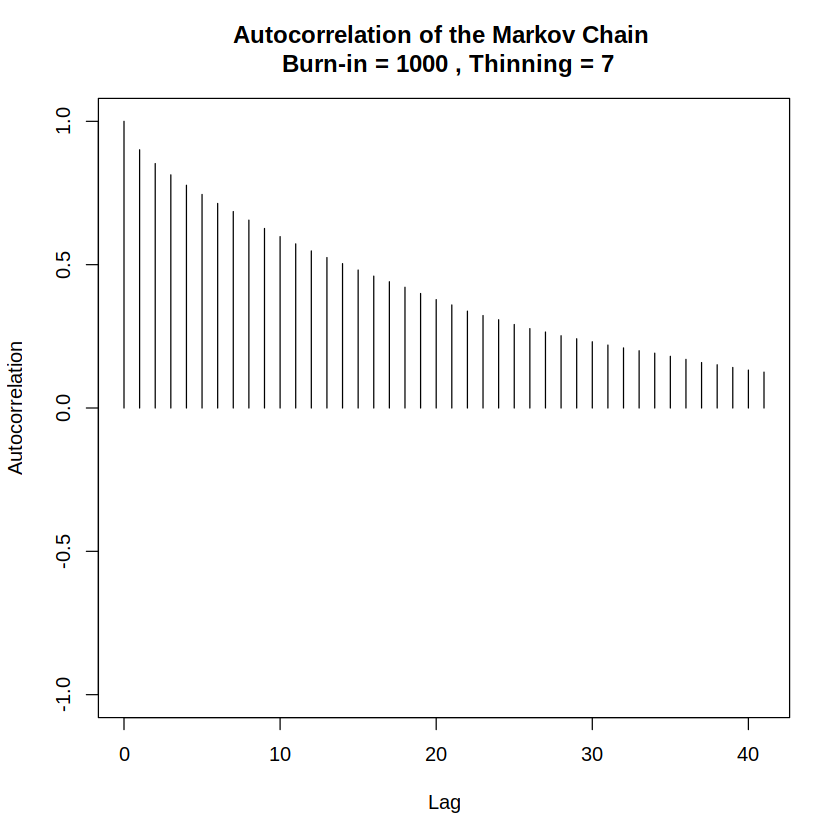

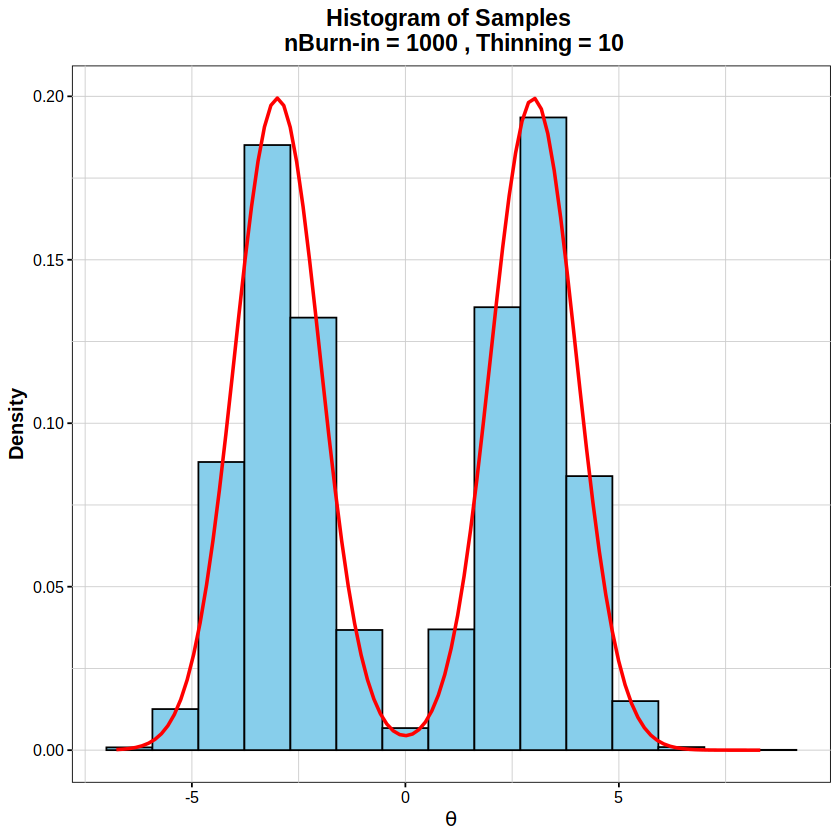

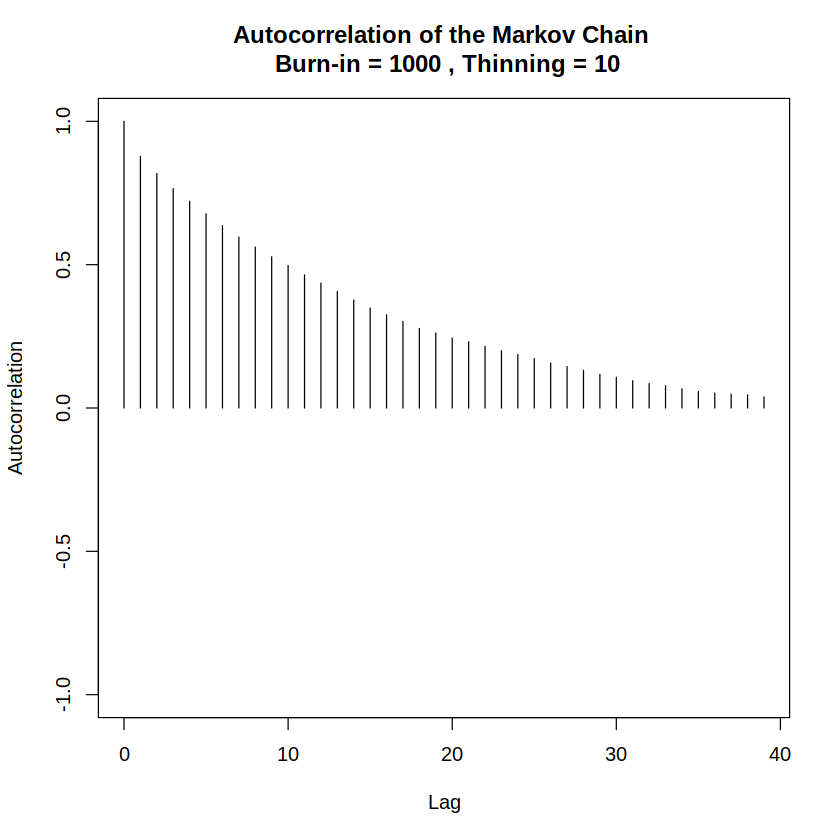

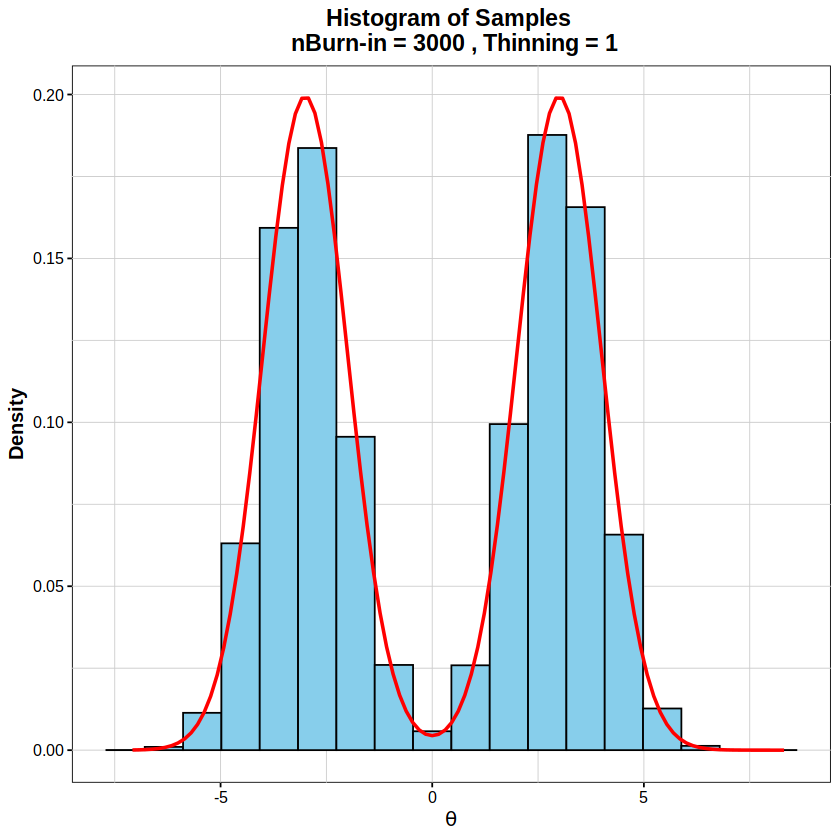

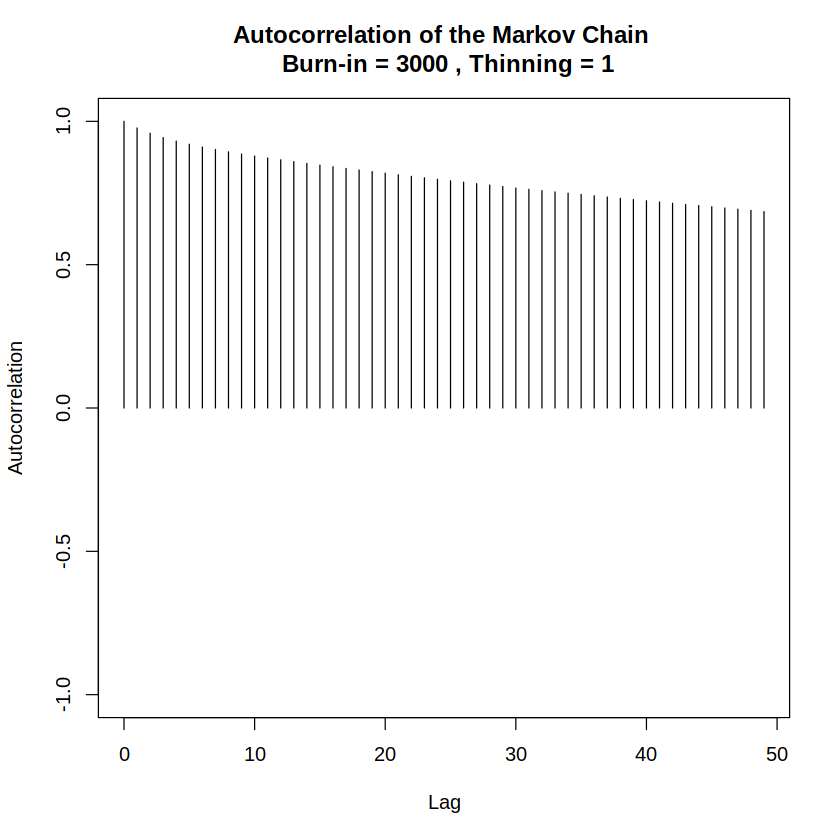

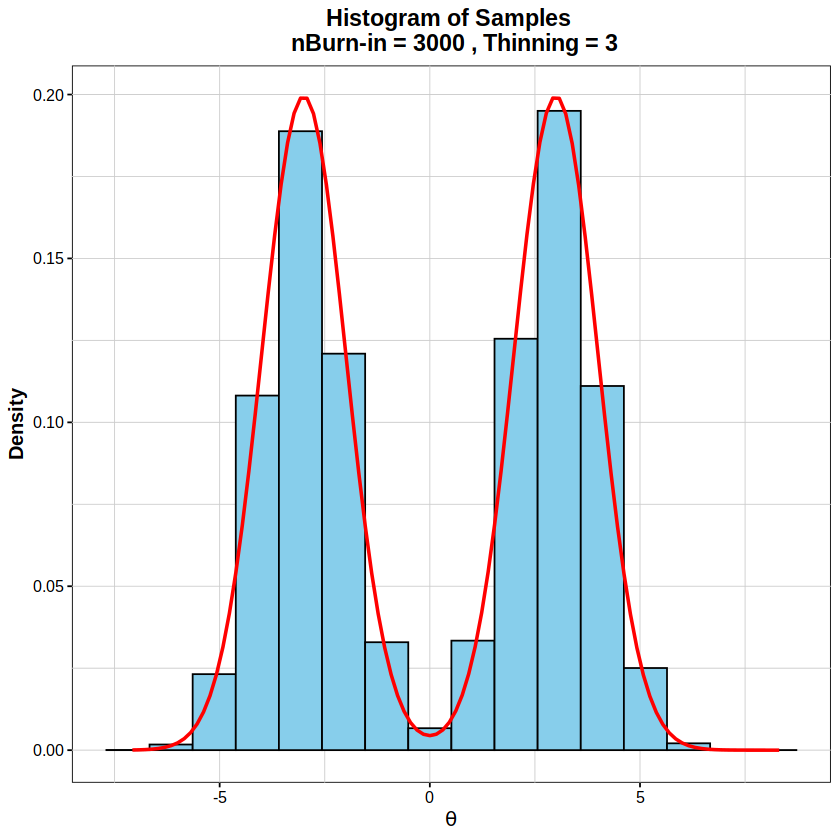

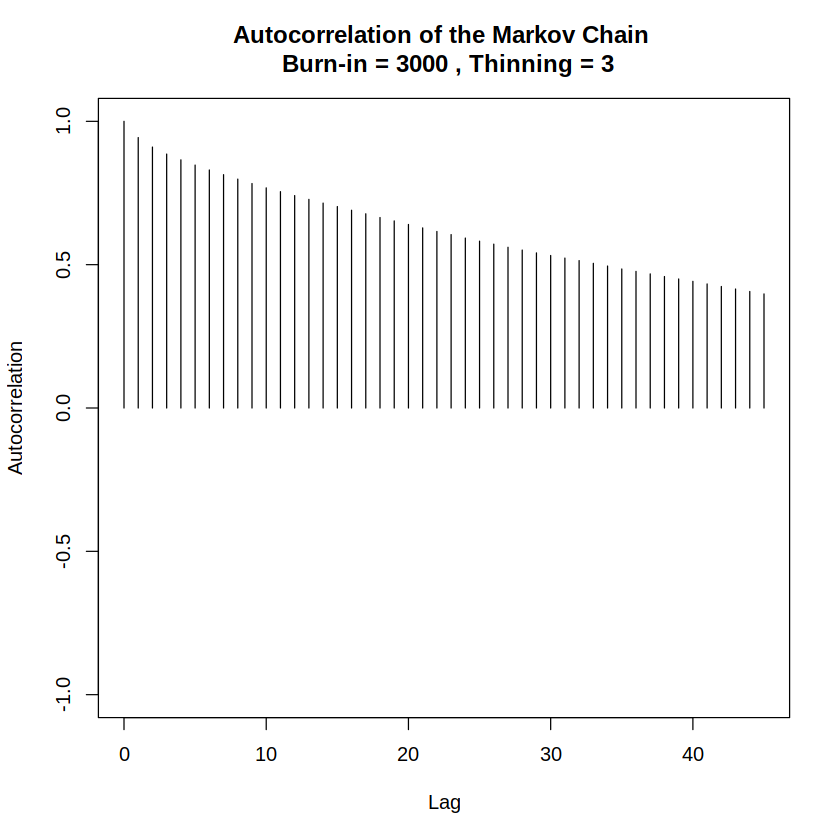

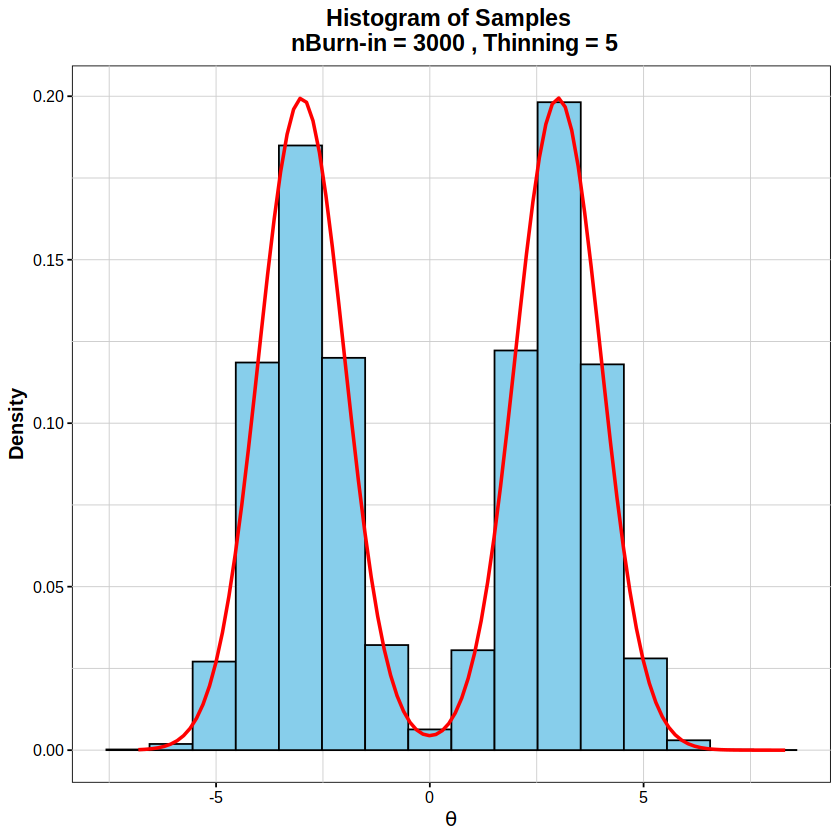

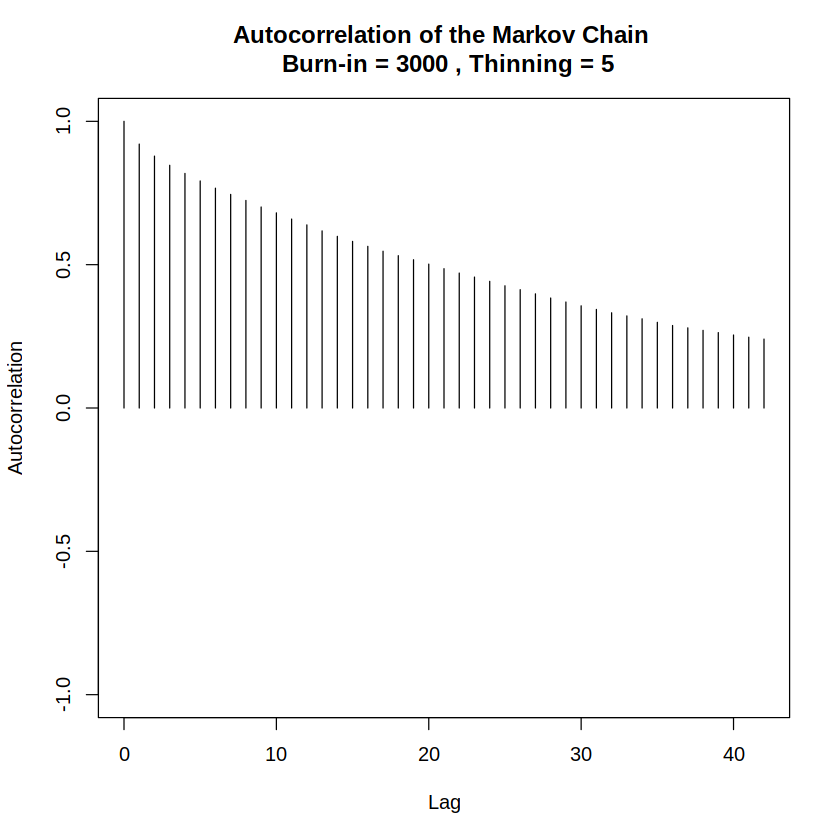

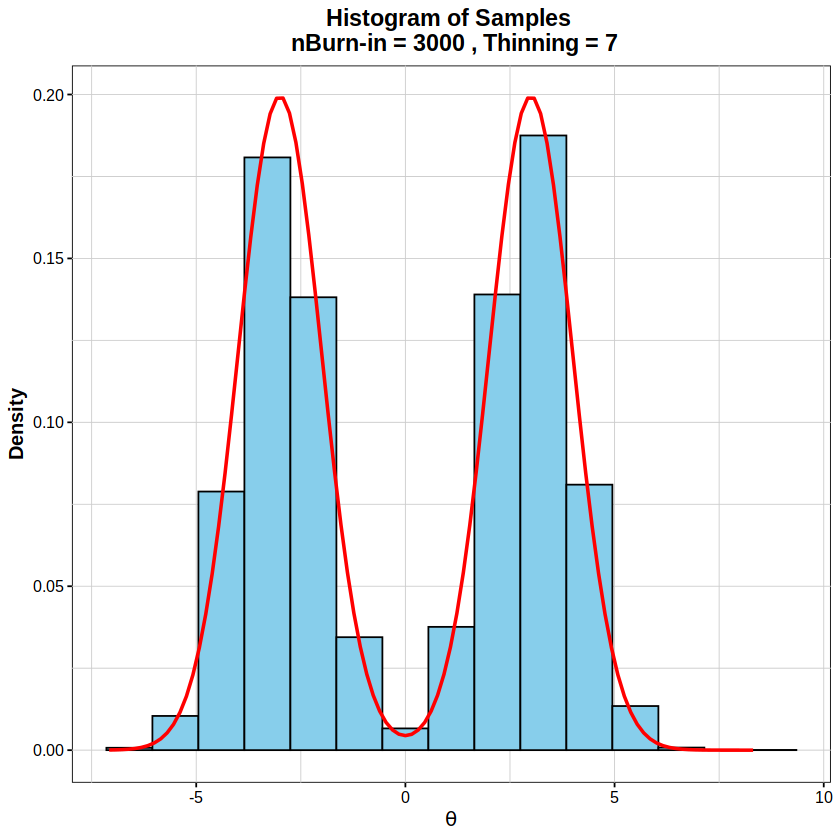

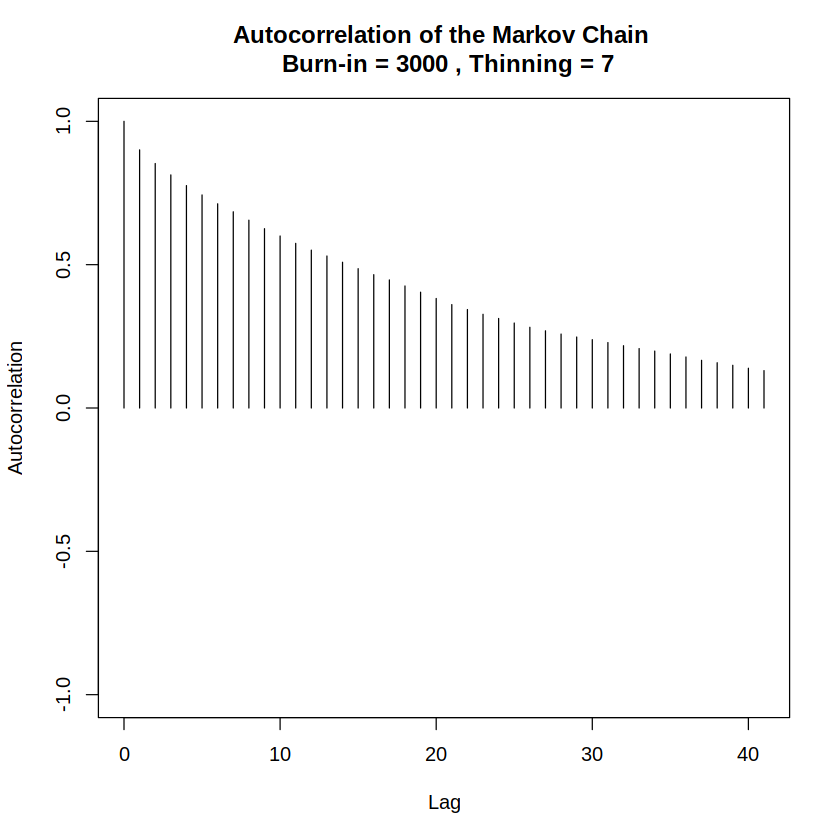

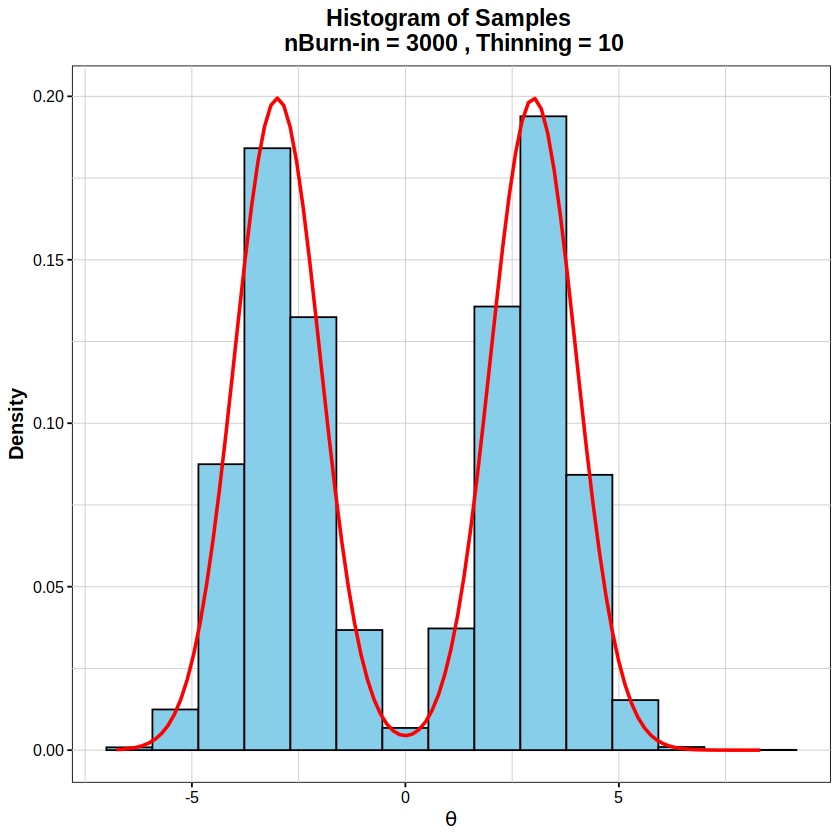

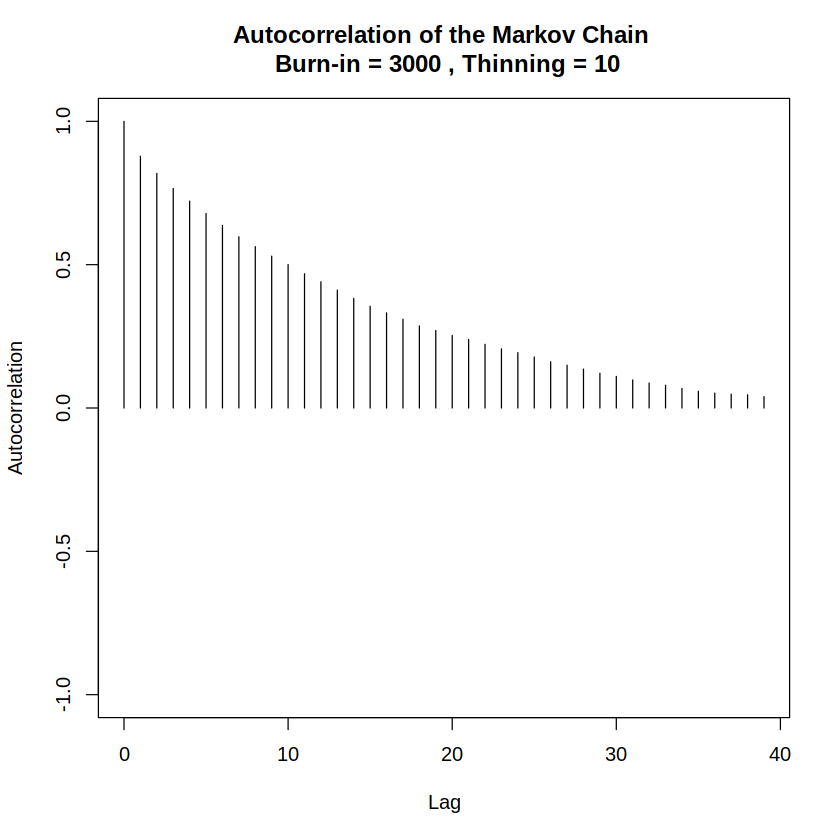

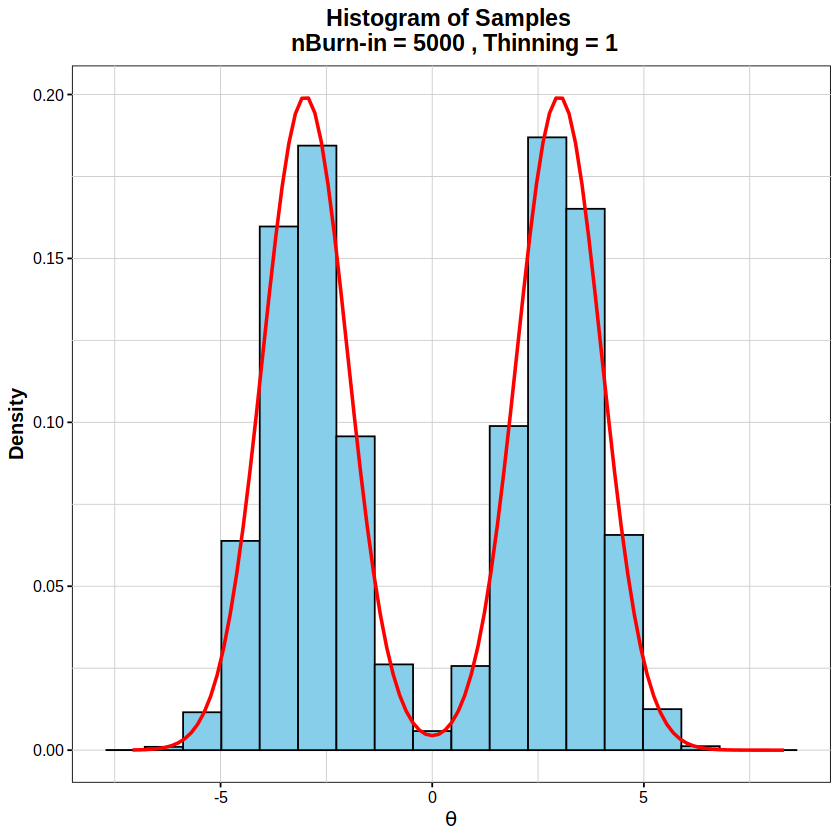

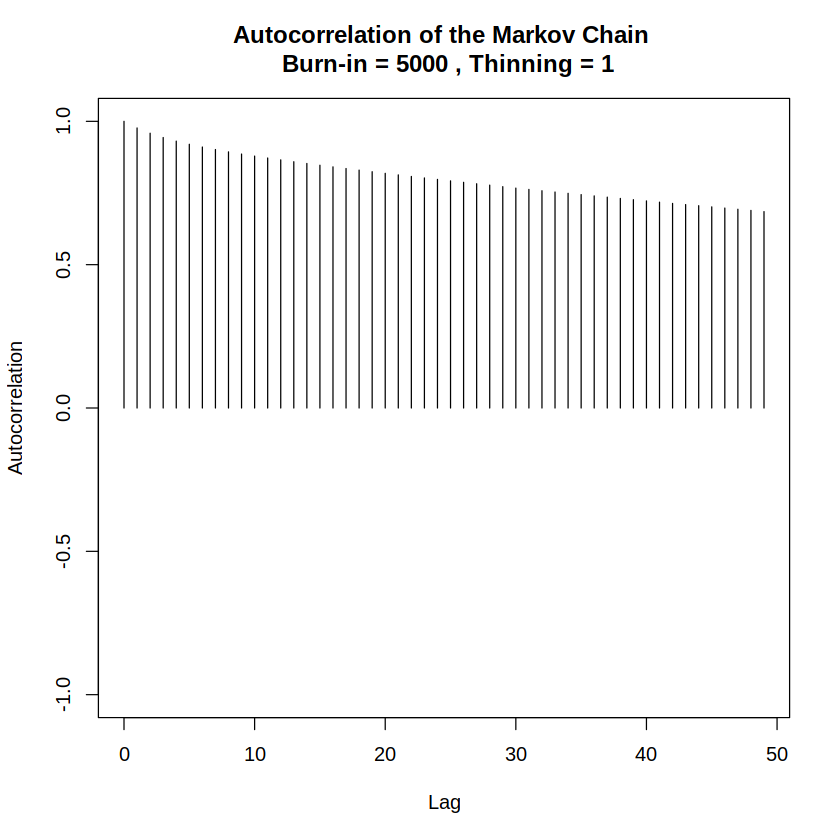

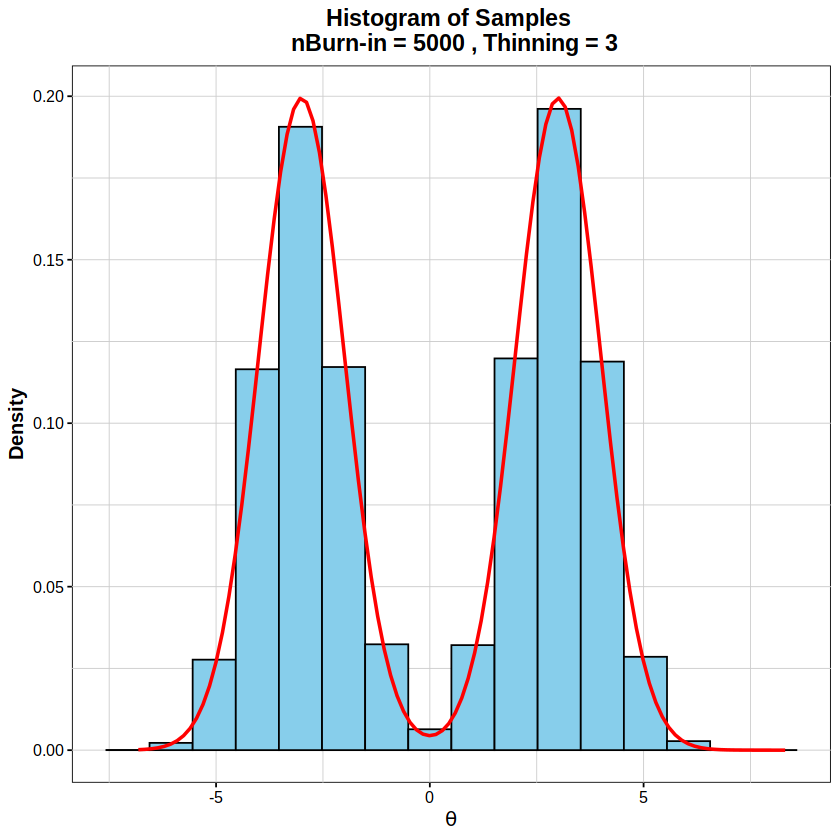

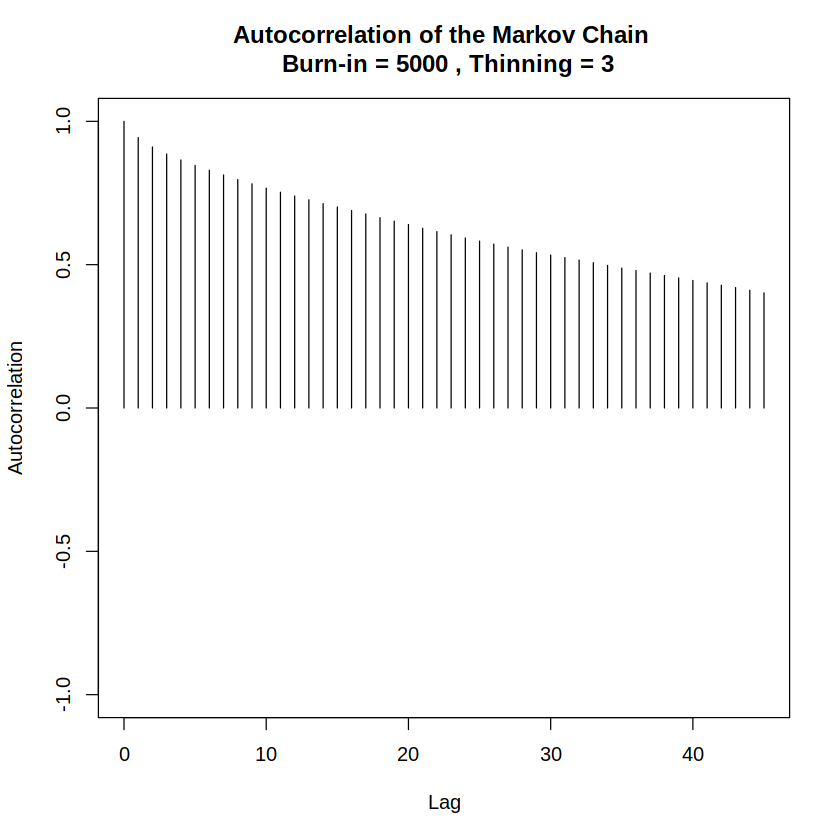

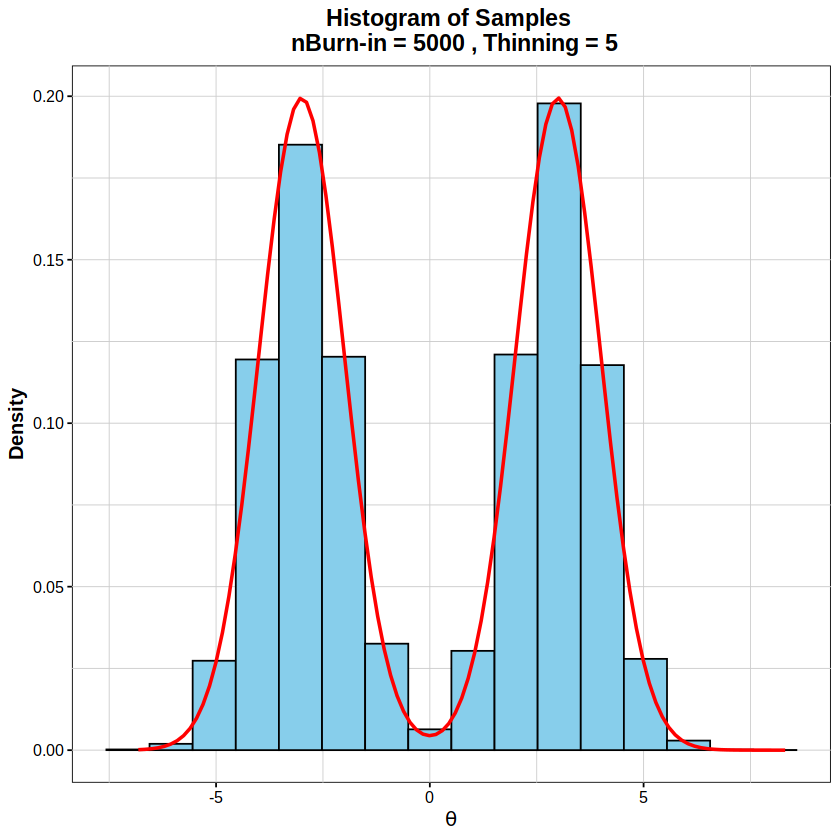

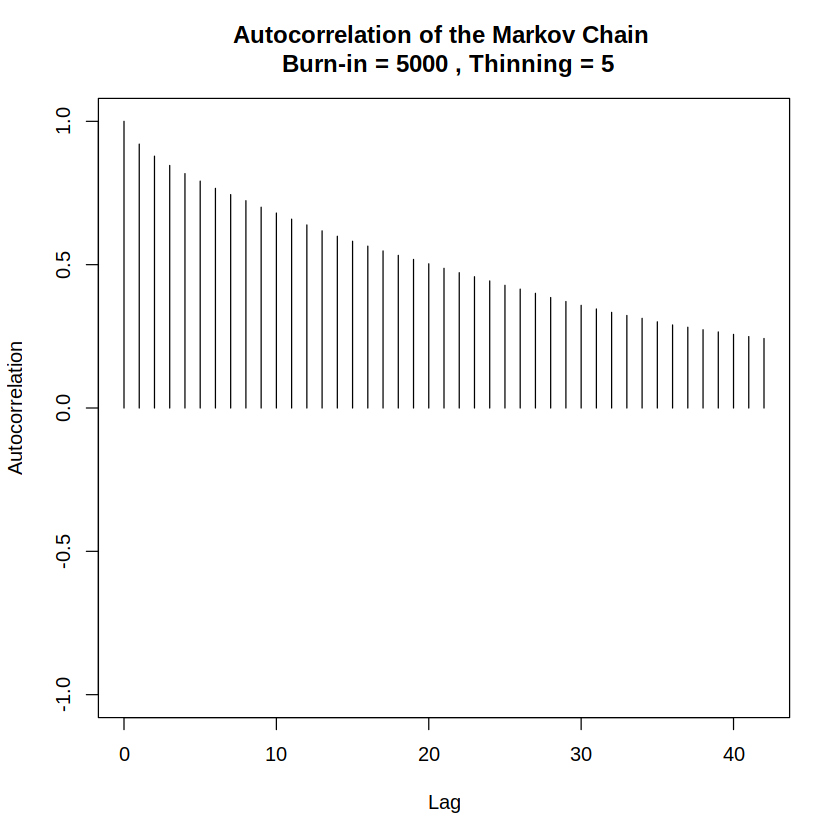

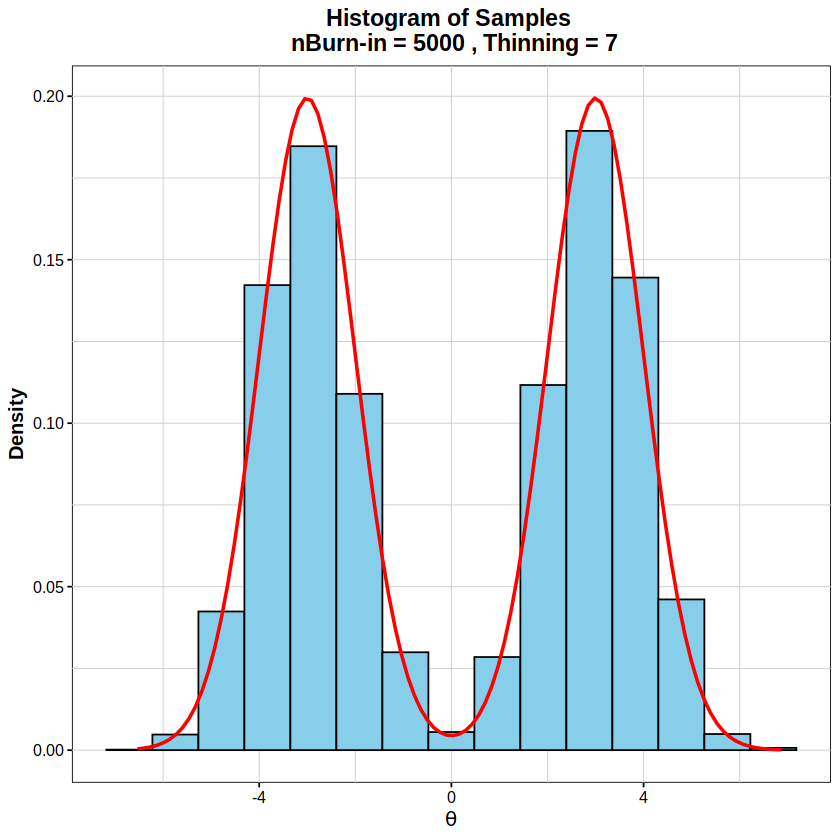

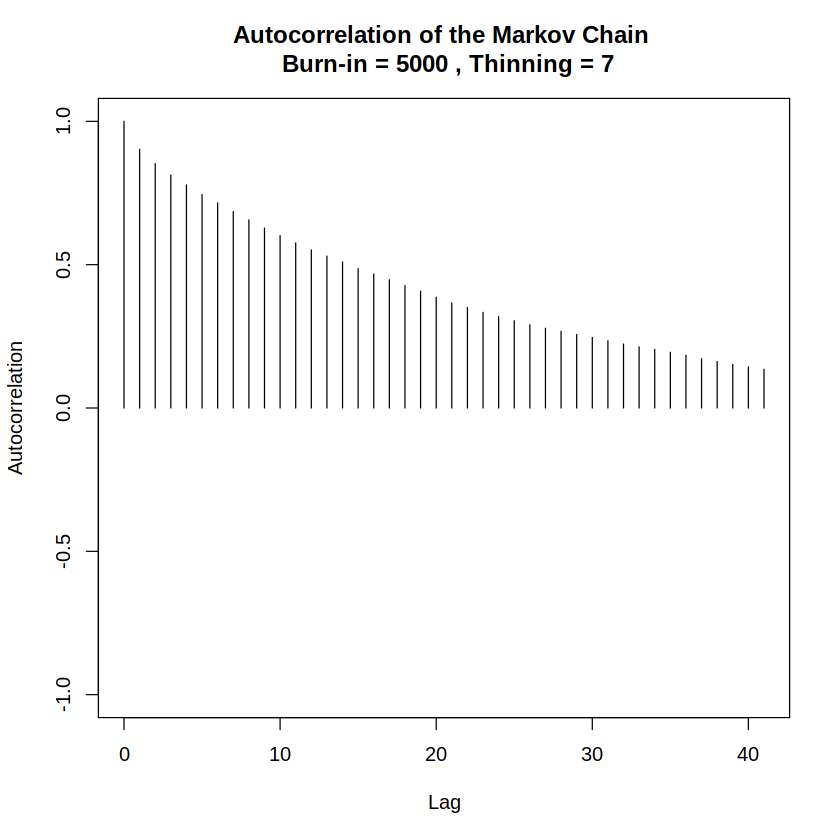

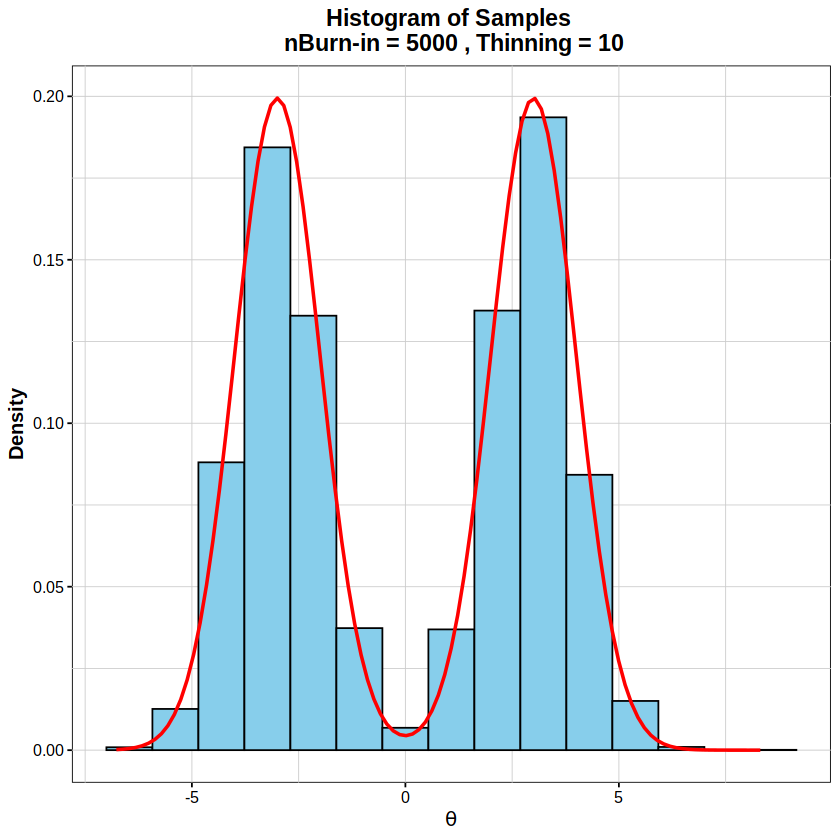

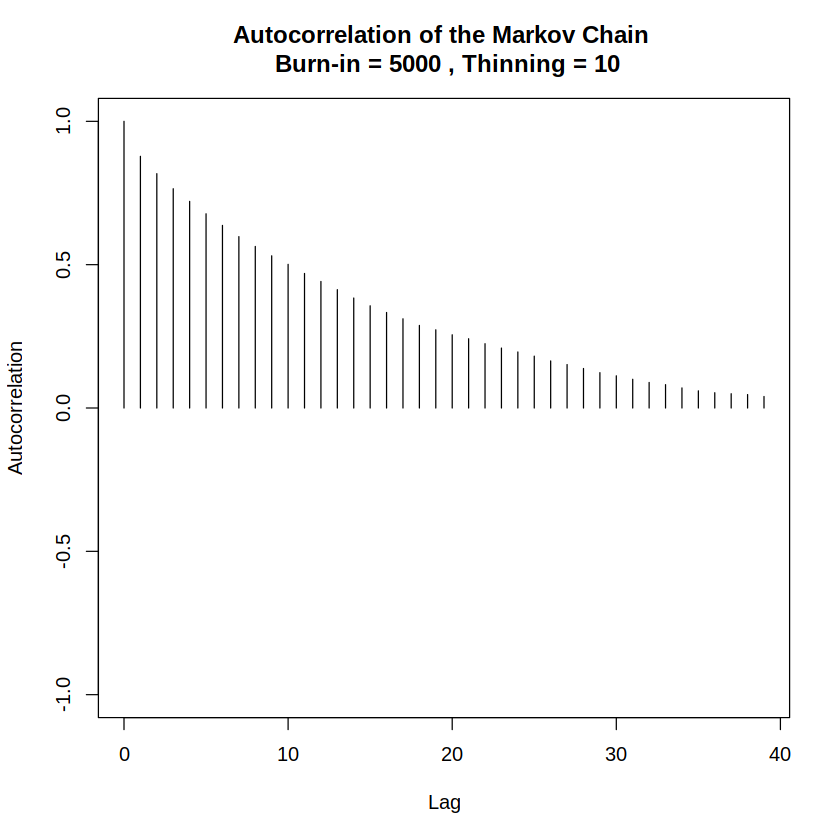

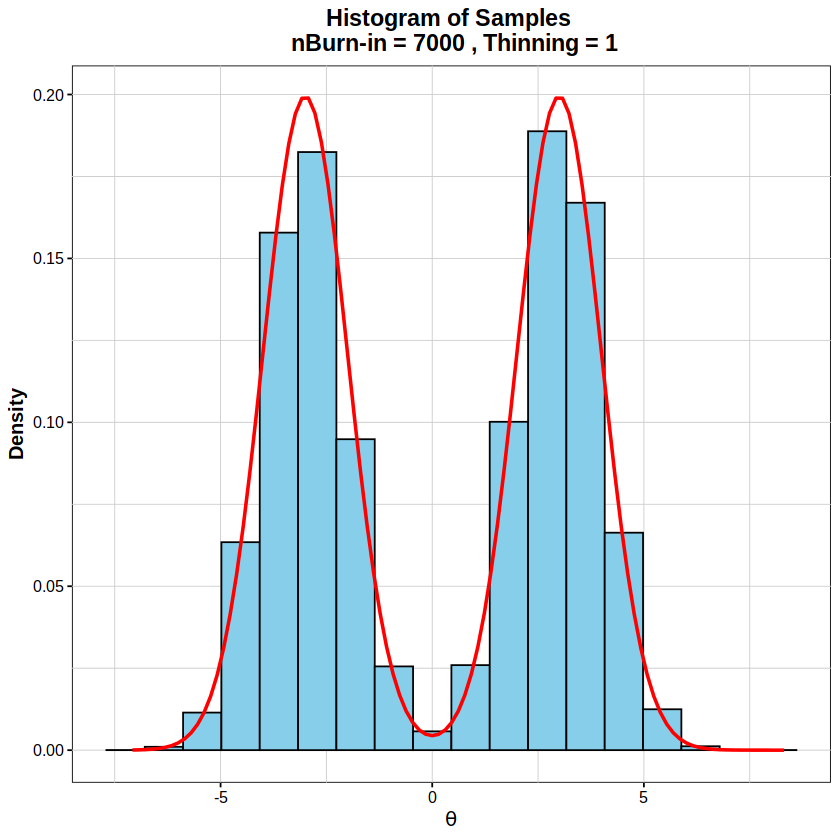

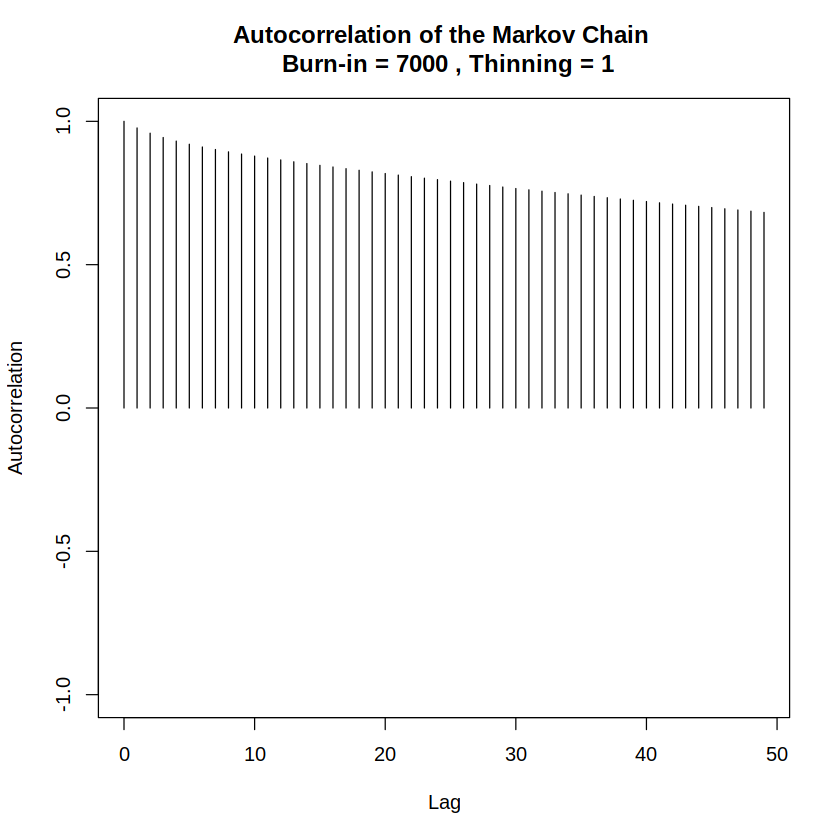

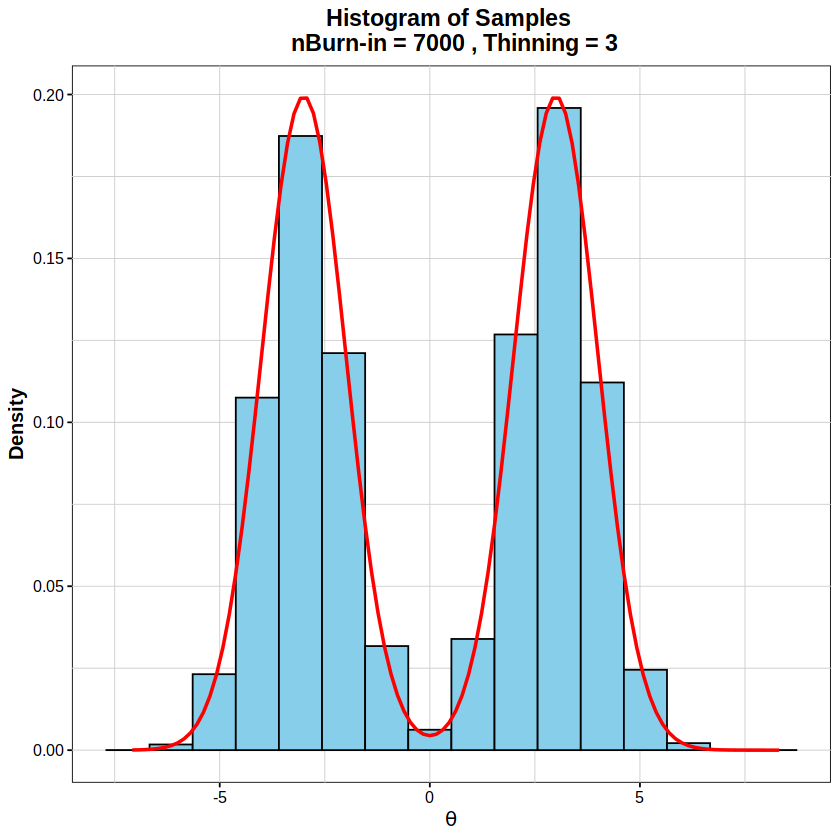

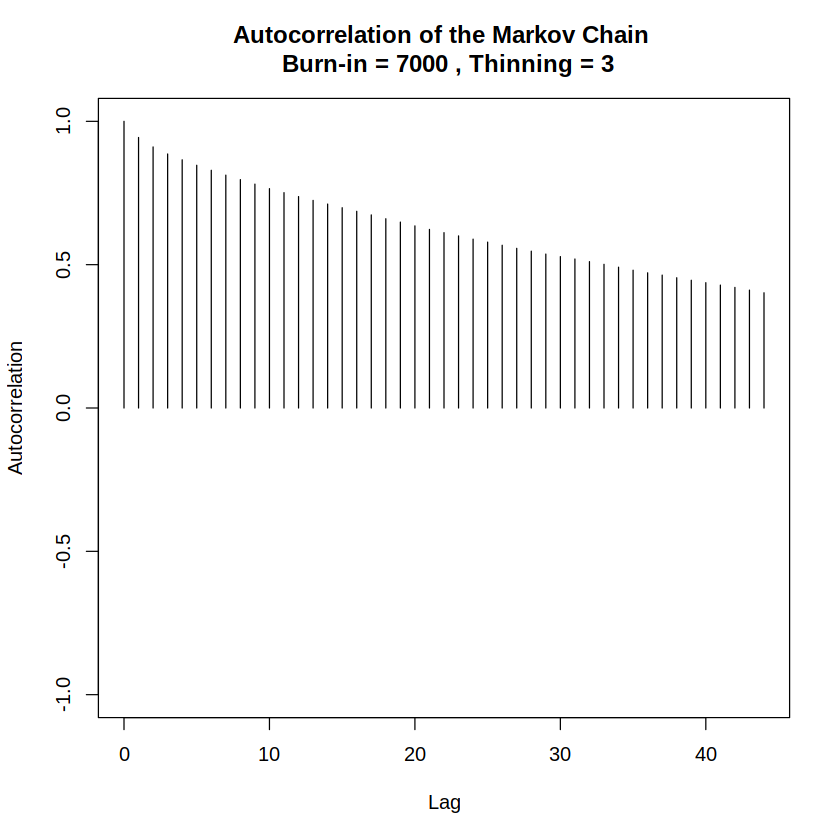

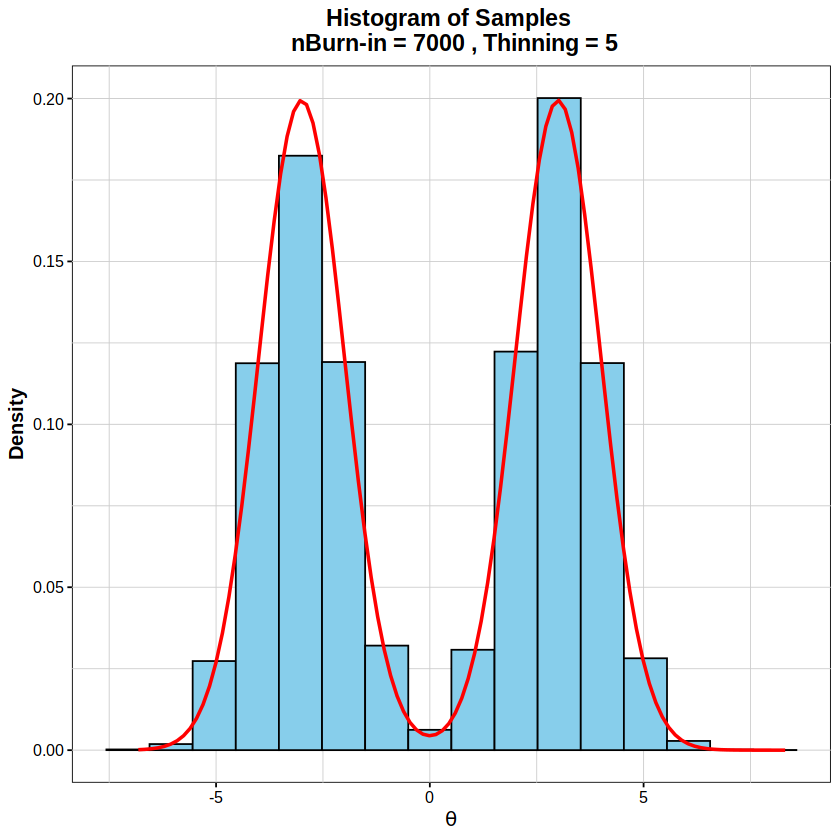

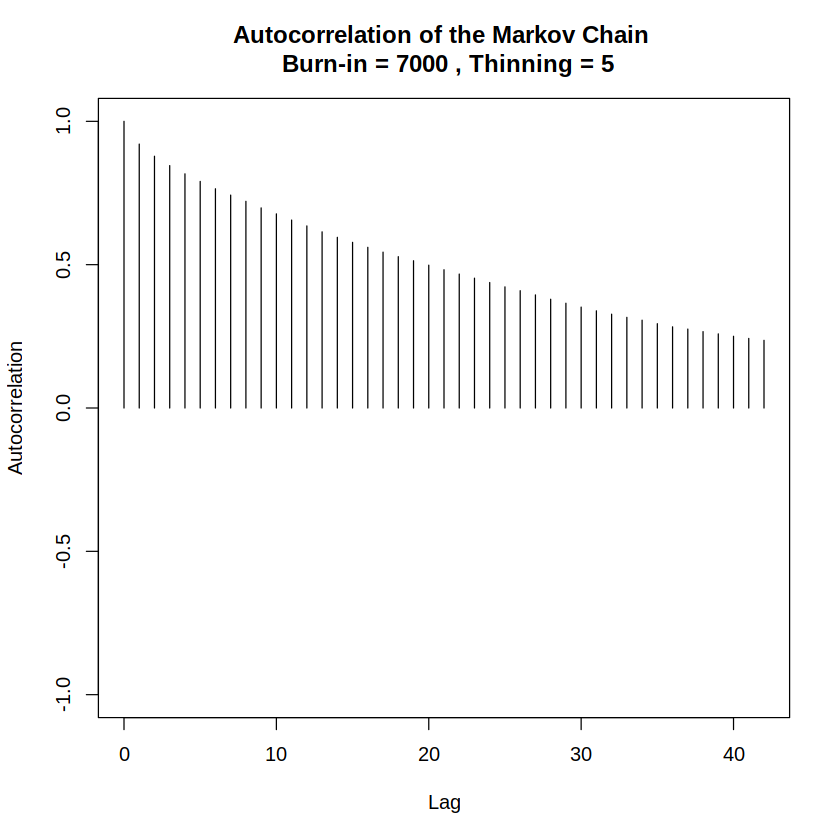

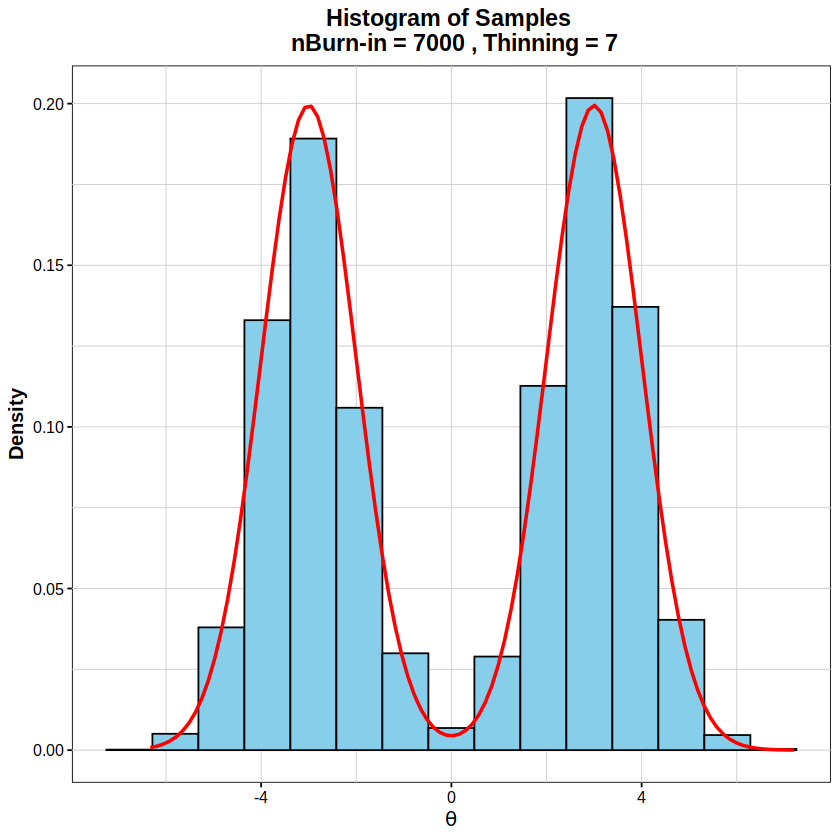

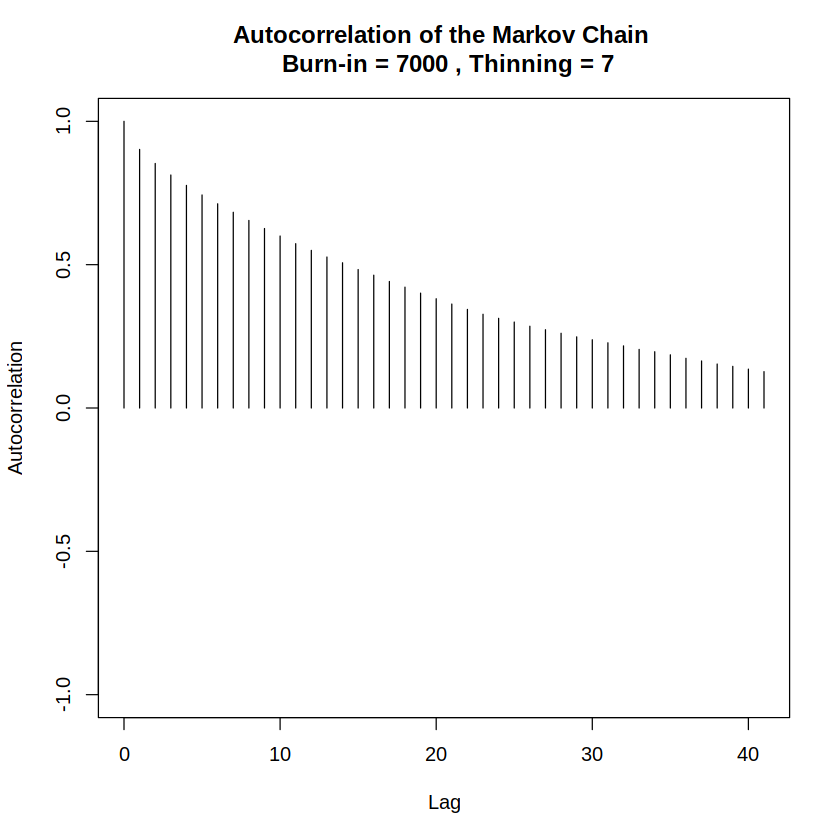

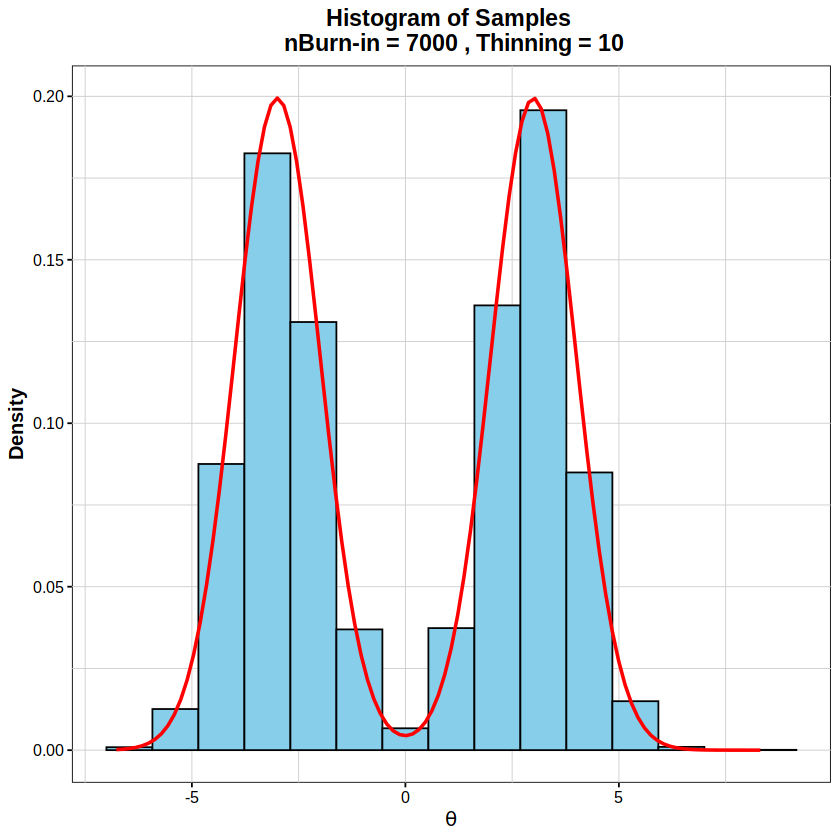

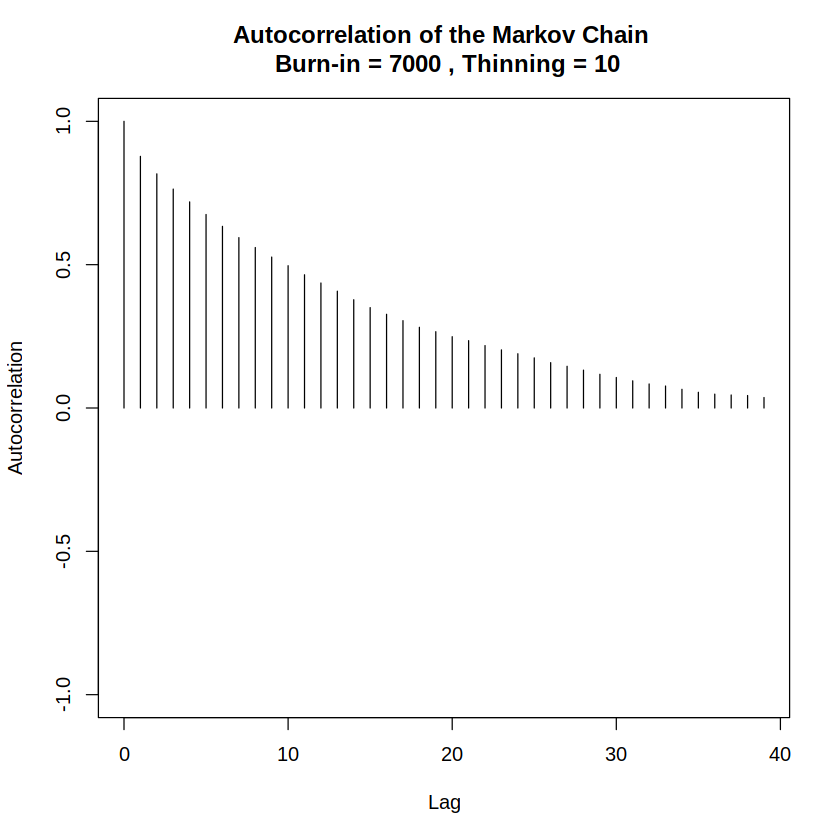

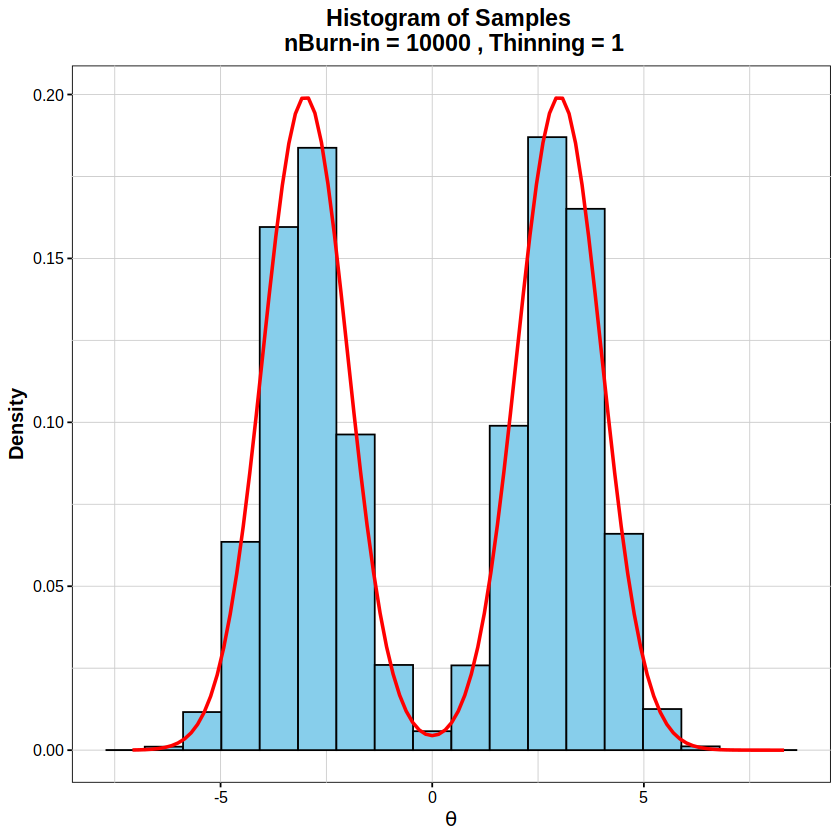

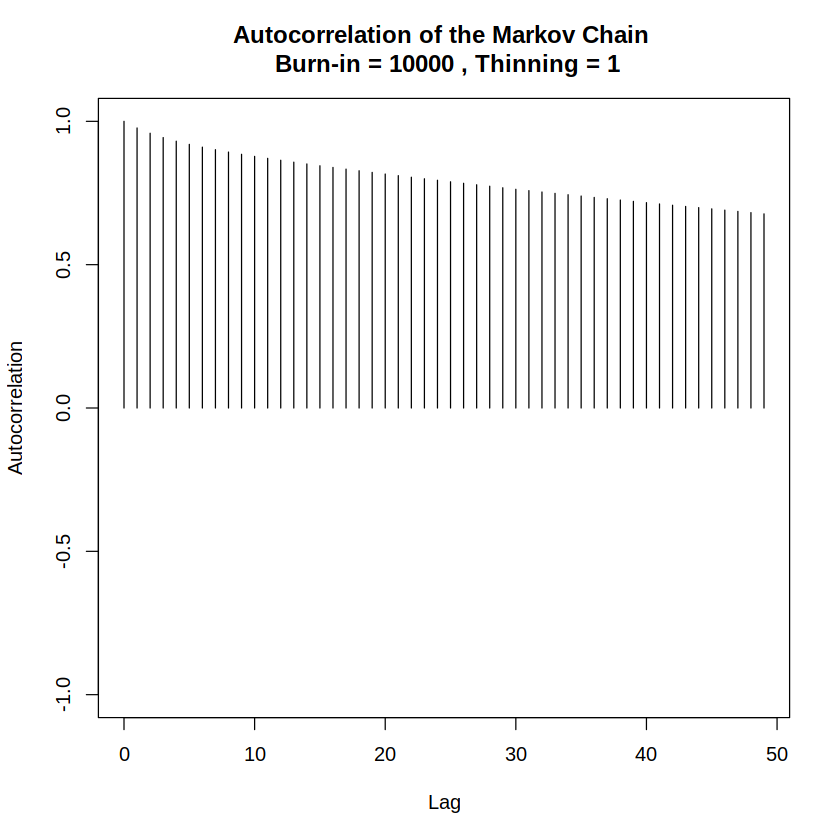

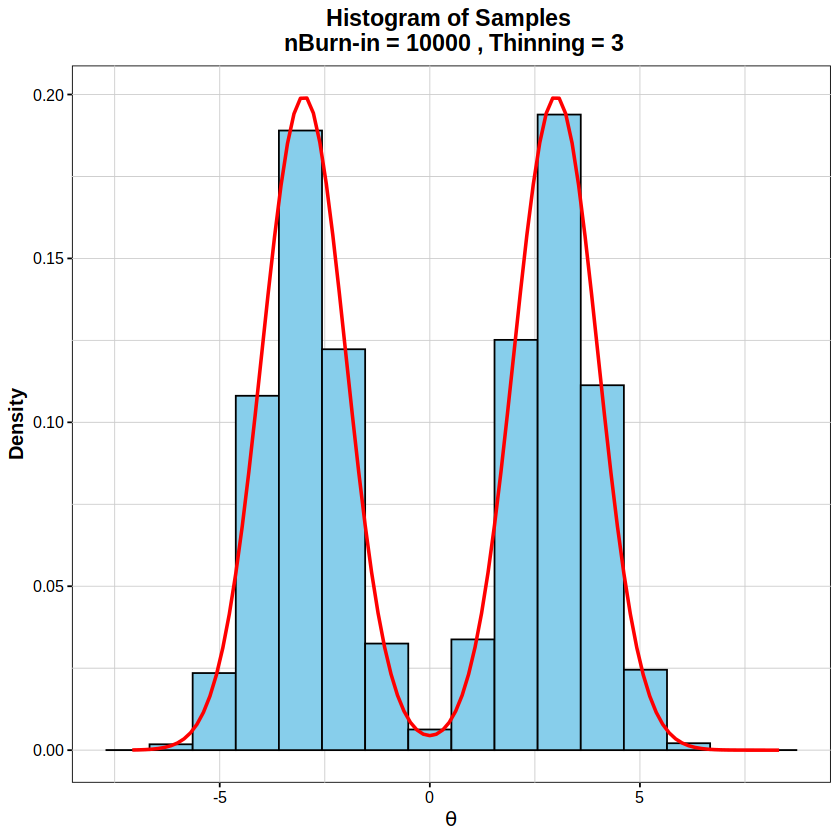

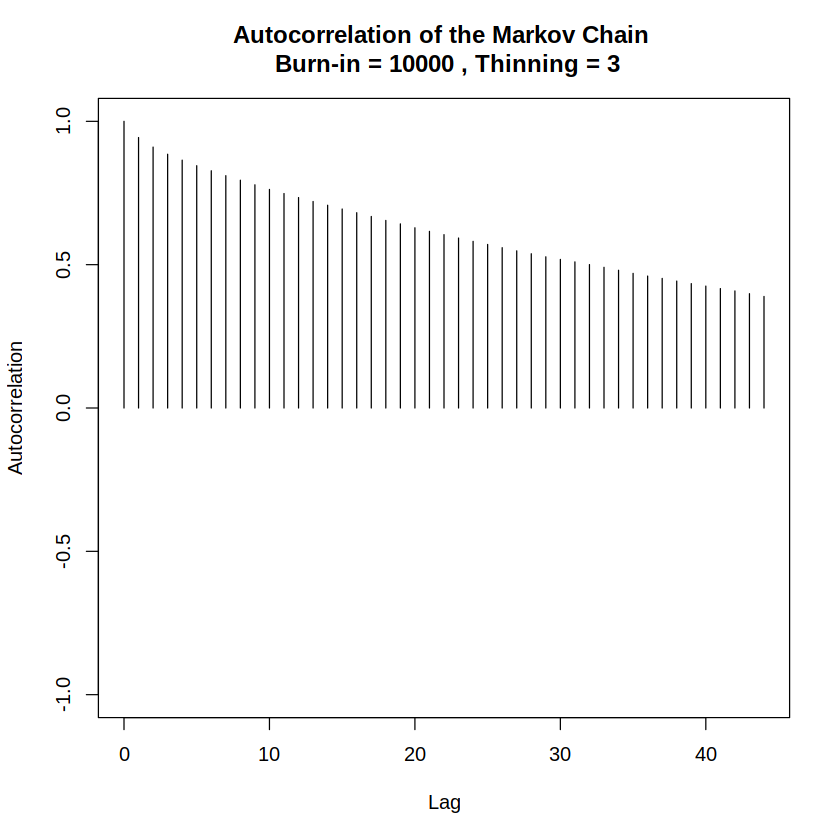

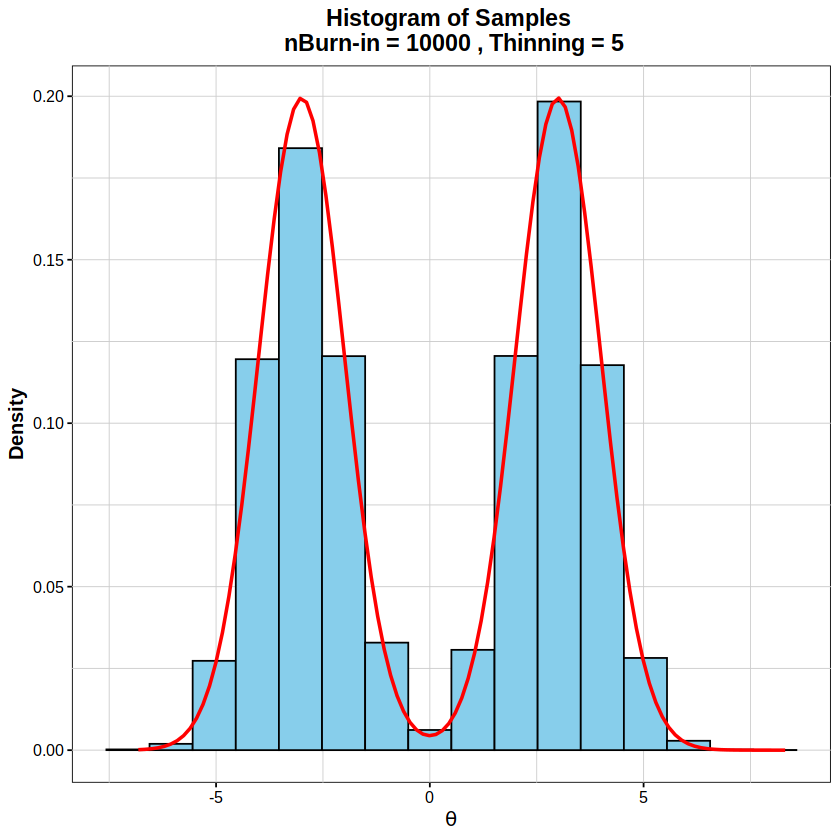

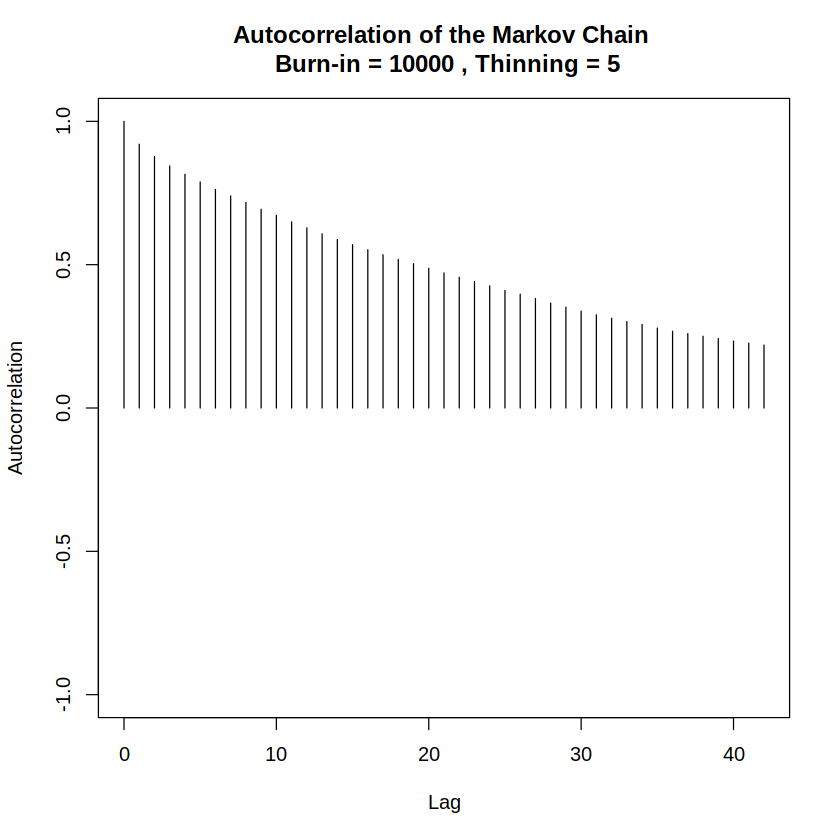

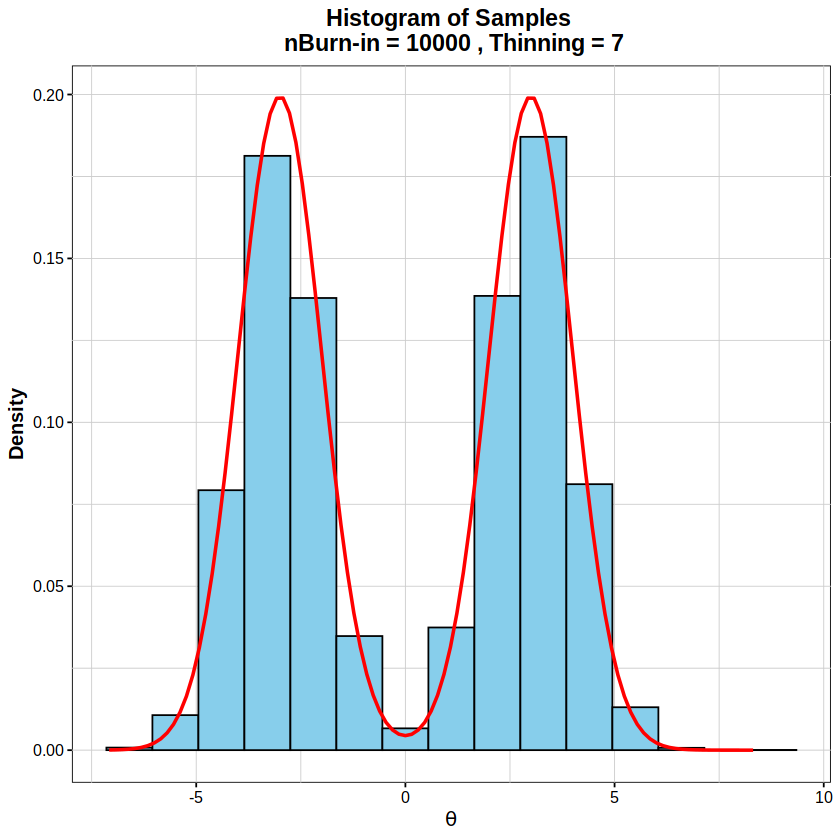

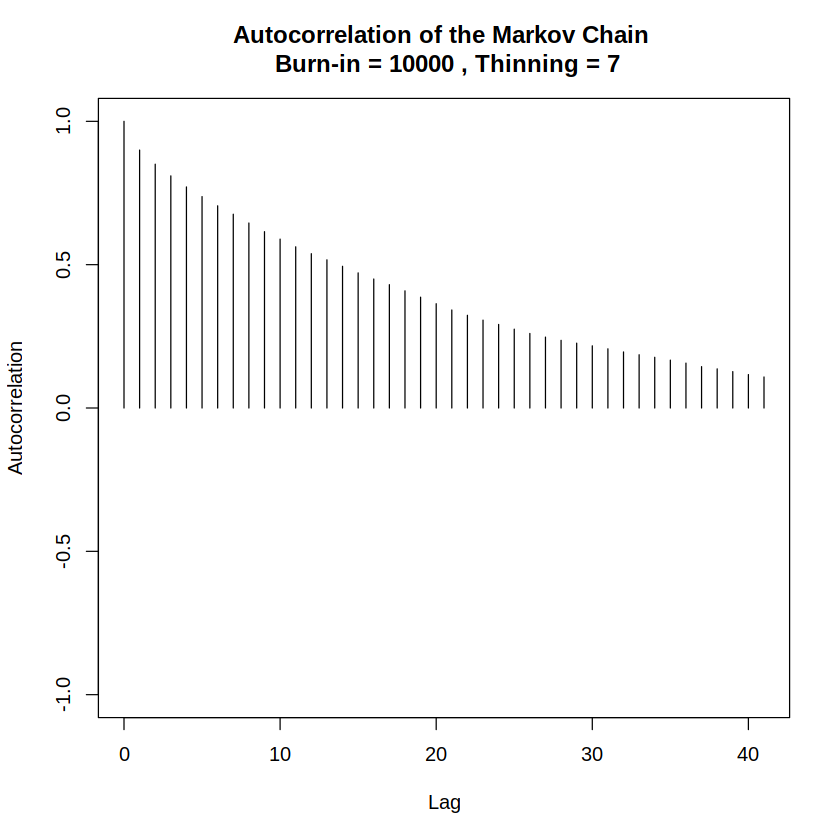

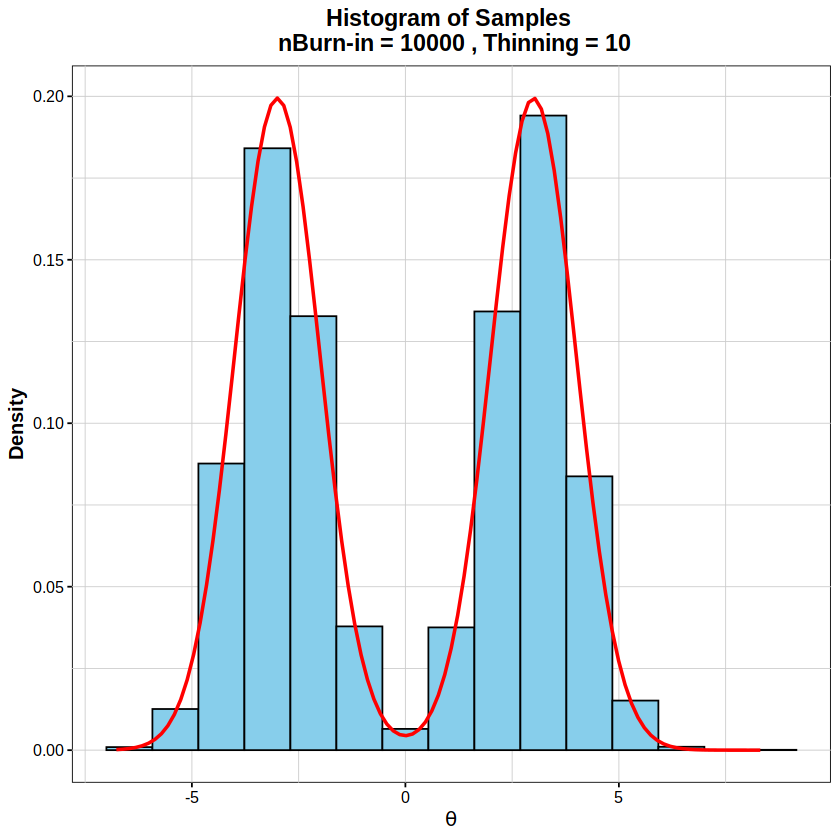



Table: Effective Sample Size (ESS) and Autocorrelation Time (ACT) for Different Burn-in and Thinning Parameters

|       | Burnin| Thinning|      ESS|       ACT|
|:------|------:|--------:|--------:|---------:|
|var1   |   1000|        1| 345.7697| 43.121825|
|var11  |   1000|        3| 337.9753| 17.726191|
|var12  |   1000|        5| 328.7431| 12.596961|
|var13  |   1000|        7| 325.1677| 10.071593|
|var14  |   1000|       10| 339.9022|  8.215163|
|var15  |   3000|        1| 336.8552| 43.089816|
|var16  |   3000|        3| 331.9273| 17.642016|
|var17  |   3000|        5| 320.9593| 12.581936|
|var18  |   3000|        7| 318.1888| 10.039365|
|var19  |   3000|       10| 333.2430|  8.207993|
|var110 |   5000|        1| 330.6899| 43.149403|
|var111 |   5000|        3| 310.7910| 17.711758|
|var112 |   5000|        5| 315.9736| 12.573778|
|var113 |   5000|        7| 315.9244| 10.261798|
|var114 |   5000|       10| 327.7358|  8.190291|
|var115 |   7000|        1| 327.7279| 43.181617|
|va

[1] "Low burning and thinning values prodocue a high ESS but a high ACT too. The best combinations of parameter is indeed the var 13."


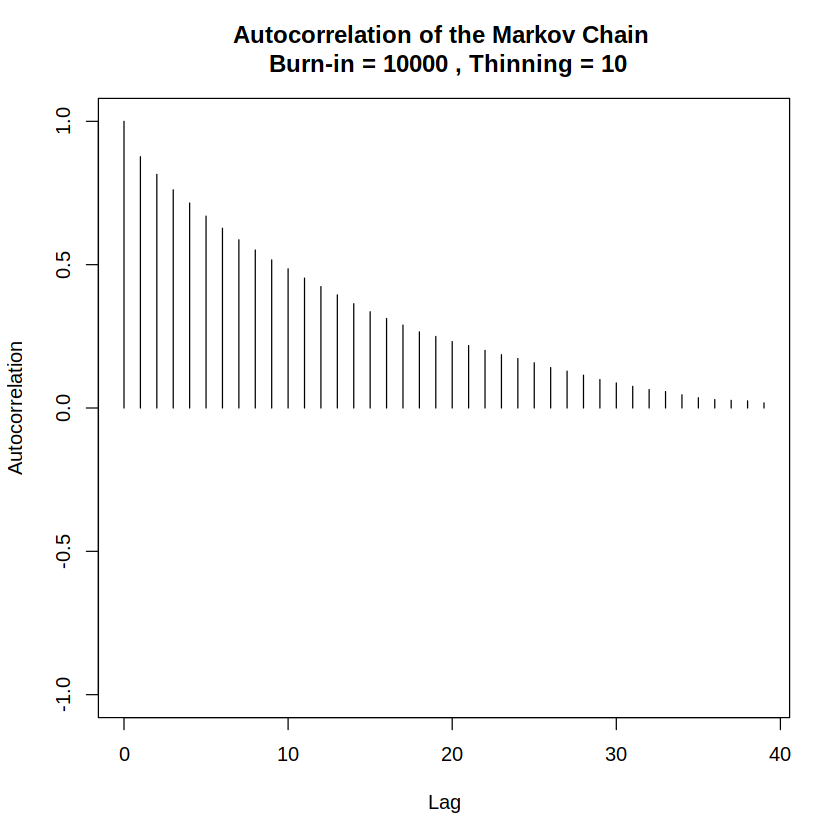

In [4]:
burnin_values = c(1000, 3000, 5000, 7000, 10000)
thin_values = c(1, 3, 5, 7, 10)

burnin_thinning = function(samples, burnin, thin) {
    if (burnin > 0) {
        samples = samples[-(1:burnin)] #removing the first burnin sample
    }
    if (thin > 1) {
        samples = samples[seq(1, length(samples), thin)] #keep every thin -th sample
    }
    return(samples)
}

results_df = data.frame(Burnin=integer(), Thinning=integer(), ESS=numeric(), ACT=numeric())

for (burnin in burnin_values) {
    for (thin in thin_values) {
        bt_samples = burnin_thinning(samples, burnin, thin)
        bt_samples_df = data.frame(samples=bt_samples)
        bt_samples_mcmc = as.mcmc(bt_samples)
        ess = effectiveSize(bt_samples_mcmc)
        act = 1 / (1 - acf(bt_samples_mcmc, plot=FALSE)$acf[2])
        results_df = rbind(results_df, data.frame(Burnin=burnin, Thinning=thin, ESS=ess, ACT=act))
        bins_sturges = ceiling(log2(length(bt_samples)) + 1)
        plot = ggplot(bt_samples_df, aes(x=samples)) +
            geom_histogram(aes(y = after_stat(density)), bins=bins_sturges, fill="skyblue", color="black") + 
            stat_function(fun=function(x) 0.5*dnorm(x, mean =-3, sd=1) + 0.5*dnorm(x, mean=3, sd=1), color = "red", linewidth = 1) + 
            labs(x=expression(theta), 
                 y="Density", 
                 title=paste("Histogram of Samples",'\n',"nBurn-in =", burnin, ", Thinning =", thin)) + 
            theme(text = element_text(size=12),
                  axis.title.x = element_text(face="bold", size=12),
                  axis.title.y = element_text(face="bold", size=12),
                  axis.text = element_text(color="black"),
                  axis.ticks = element_line(color="black"),
                  plot.title = element_text(hjust=0.5, face="bold", size=14),
                  panel.background = element_rect(fill = "white", color = "black"),
                  panel.grid.major = element_line(linewidth=0.25, linetype='solid', color="grey80"),
                  panel.grid.minor = element_line(linewidth=0.25, linetype='solid', color="grey80"))
        print(plot)
        autocorr.plot(bt_samples_mcmc, main=paste("Autocorrelation of the Markov Chain", '\n', "Burn-in =", burnin, ", Thinning =", thin))
    }
}

kable(results_df, caption = "Effective Sample Size (ESS) and Autocorrelation Time (ACT) for Different Burn-in and Thinning Parameters")
print("Low burning and thinning values prodocue a high ESS but a high ACT too. The best combinations of parameter is indeed the var 13.")

### Exercise 2

A set of measured data should follow, according to the physics model applied to them, a linear behavior. Data are the following:

$$
\begin{array}{c|cccccccc}
Y & -7.821 & -1.494 & -15.444 & -10.807 & -13.735 & -14.442 & -15.892 & -18.326 \\
\hline
X & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 \\
\end{array}
$$

a) Perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS (just another gibbs sampler), assuming that data follow the model:

$Z[i] \sim a + b * X[i]$

And the likelihood of the measured data follow a Gaussian likelihood distribution:

$Y[i] \sim dnorm(Z[i], c)$

You can constrain the parameter a, b and c to the following intervals: $a \in [1,10], \; b \in [-1,3] \; \text{and} \; c \in [0.034,4]$



In [5]:
X = seq(5,12,1)
Y = c(-7.821, -1.494, -15.444, -10.807, -13.735, -14.442, -15.892, -18.326)
N= length(Y)
data_list = list(X=X, Y=Y, N=N) #for jags

#i need to describe the model as a string for jags. a, b, c are priors. a is intercept, b is slope and c is the inverse of the variance
model = "model {
    for (i in 1:N) {
        Y[i] ~ dnorm(mu[i], c)
        mu[i] = a + b * X[i]
    }
    a ~ dunif(1, 10)
    b ~ dunif(-1, 3)
    c ~ dunif(0.034, 4)
}"

model_connection = textConnection(model)
lin_reg = jags.model(model_connection, data=data_list, n.chains=5, n.adapt=10000) #n.chains number of chains, n.adapt number of adapt steps

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 3
   Total graph size: 42

Initializing model



b) Run JAGS experimenting with the burnin and number of iterations of the chain. Plot the evolution of the chains and the posterior distributions of a and b. Compute the 95% credibility interval for the parameters.

[[1]]
        lower    upper
var1 1.000251 2.449437
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000015 2.384832
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000004 2.383445
attr(,"Probability")
[1] 0.95

[[4]]
        lower    upper
var1 1.000232 2.340186
attr(,"Probability")
[1] 0.95

[[5]]
        lower    upper
var1 1.000155 2.479471
attr(,"Probability")
[1] 0.95

[[1]]
          lower      upper
var1 -0.9999981 -0.8397371
attr(,"Probability")
[1] 0.95

[[2]]
          lower      upper
var1 -0.9999918 -0.8447286
attr(,"Probability")
[1] 0.95

[[3]]
          lower      upper
var1 -0.9999998 -0.8485061
attr(,"Probability")
[1] 0.95

[[4]]
          lower      upper
var1 -0.9999924 -0.8435375
attr(,"Probability")
[1] 0.95

[[5]]
         lower      upper
var1 -0.999981 -0.8491707
attr(,"Probability")
[1] 0.95

[[1]]
        lower    upper
var1 1.000348 2.372434
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000152 2.4040

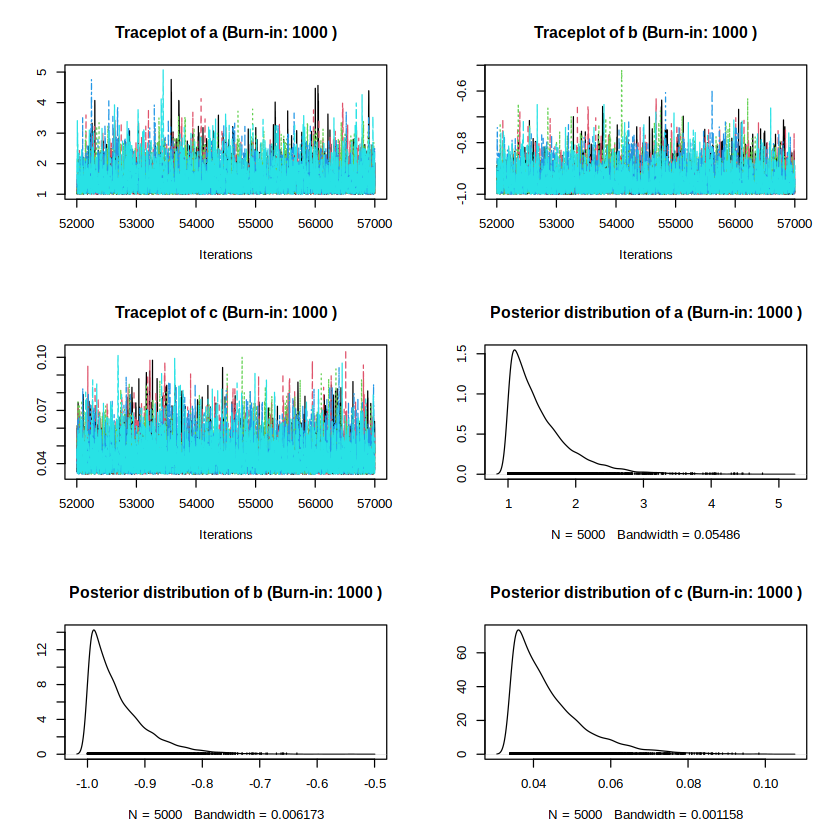

[[1]]
        lower    upper
var1 1.000074 2.417372
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000121 2.376566
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000071 2.424561
attr(,"Probability")
[1] 0.95

[[4]]
        lower    upper
var1 1.000049 2.309576
attr(,"Probability")
[1] 0.95

[[5]]
        lower    upper
var1 1.000167 2.364278
attr(,"Probability")
[1] 0.95

[[1]]
        lower     upper
var1 -0.99999 -0.849224
attr(,"Probability")
[1] 0.95

[[2]]
          lower      upper
var1 -0.9999935 -0.8563162
attr(,"Probability")
[1] 0.95

[[3]]
         lower     upper
var1 -0.999992 -0.843376
attr(,"Probability")
[1] 0.95

[[4]]
          lower      upper
var1 -0.9999992 -0.8451948
attr(,"Probability")
[1] 0.95

[[5]]
         lower      upper
var1 -0.999992 -0.8531377
attr(,"Probability")
[1] 0.95



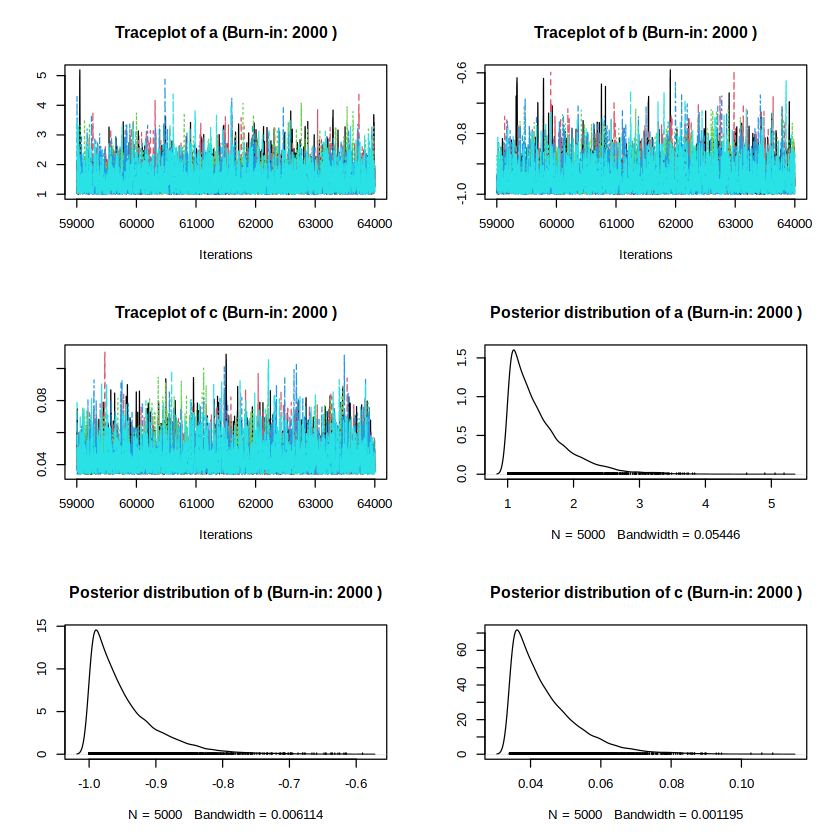

[[1]]
        lower    upper
var1 1.000002 2.308957
attr(,"Probability")
[1] 0.95

[[2]]
       lower    upper
var1 1.00004 2.464944
attr(,"Probability")
[1] 0.95

[[3]]
        lower    upper
var1 1.000045 2.430819
attr(,"Probability")
[1] 0.95

[[4]]
        lower    upper
var1 1.000094 2.406907
attr(,"Probability")
[1] 0.95

[[5]]
        lower    upper
var1 1.000038 2.542407
attr(,"Probability")
[1] 0.95

[[1]]
          lower      upper
var1 -0.9999929 -0.8494617
attr(,"Probability")
[1] 0.95

[[2]]
          lower     upper
var1 -0.9999802 -0.841544
attr(,"Probability")
[1] 0.95

[[3]]
          lower      upper
var1 -0.9999953 -0.8385179
attr(,"Probability")
[1] 0.95

[[4]]
          lower      upper
var1 -0.9999694 -0.8499469
attr(,"Probability")
[1] 0.95

[[5]]
          lower      upper
var1 -0.9999954 -0.8448915
attr(,"Probability")
[1] 0.95



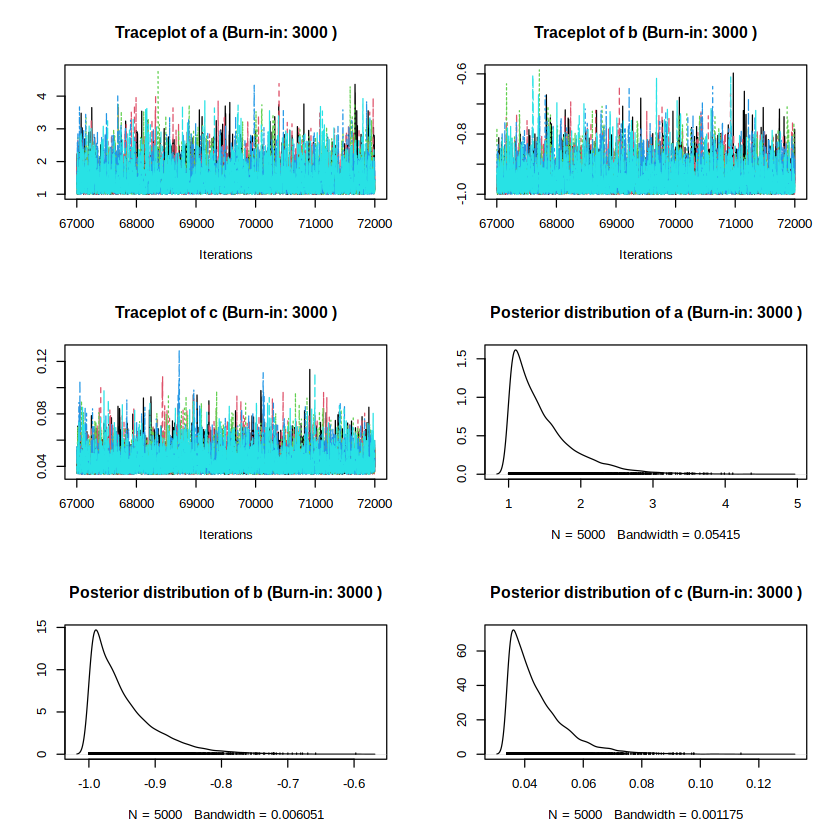

[[1]]
       lower   upper
var1 1.00008 2.41523
attr(,"Probability")
[1] 0.95

[[2]]
        lower    upper
var1 1.000006 2.447075
attr(,"Probability")
[1] 0.95

[[3]]
       lower    upper
var1 1.00001 2.403686
attr(,"Probability")
[1] 0.95

[[4]]
        lower    upper
var1 1.000027 2.403709
attr(,"Probability")
[1] 0.95

[[5]]
        lower    upper
var1 1.000108 2.335706
attr(,"Probability")
[1] 0.95

[[1]]
          lower      upper
var1 -0.9999971 -0.8448851
attr(,"Probability")
[1] 0.95

[[2]]
          lower     upper
var1 -0.9999983 -0.841282
attr(,"Probability")
[1] 0.95

[[3]]
          lower      upper
var1 -0.9999935 -0.8481644
attr(,"Probability")
[1] 0.95

[[4]]
         lower      upper
var1 -0.999999 -0.8528206
attr(,"Probability")
[1] 0.95

[[5]]
          lower      upper
var1 -0.9999962 -0.8503329
attr(,"Probability")
[1] 0.95



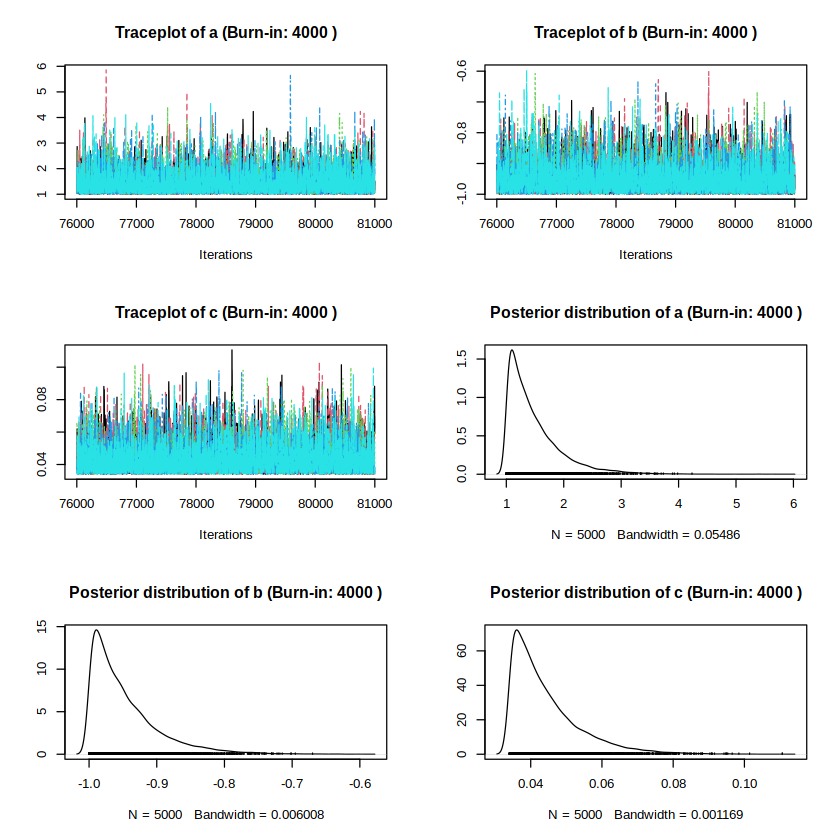

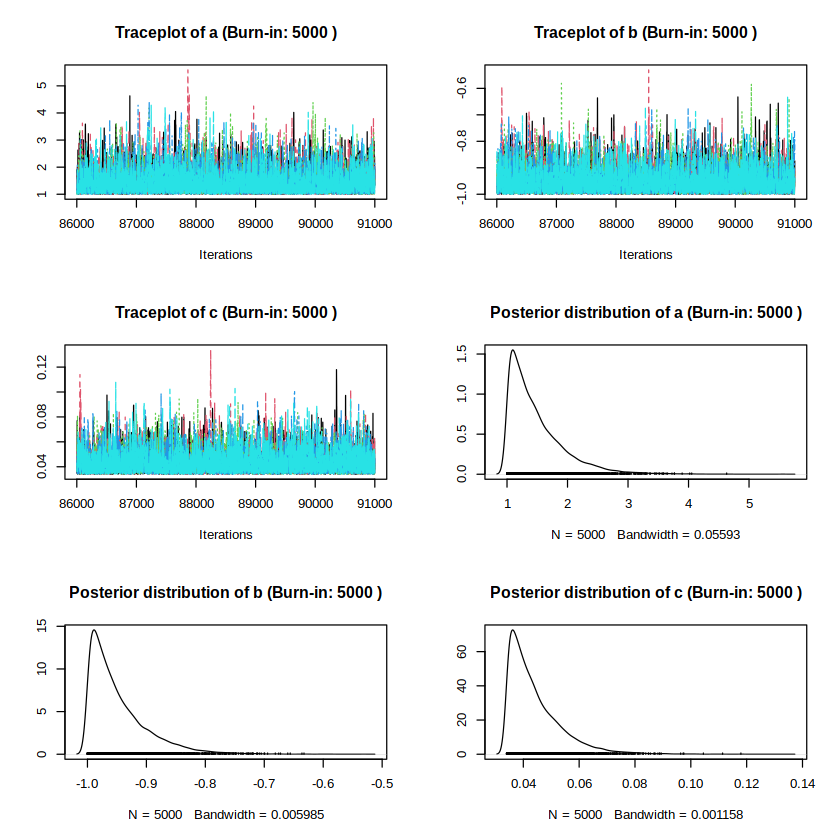

In [11]:
burnin = seq(1000, 5000, 1000)
n = 5000
parameters = c("a", "b", "c")

for (i in burnin) {
    update(lin_reg, i)
    samples = coda.samples(lin_reg, variable.names=c("a", "b", "c"), n.iter=n)
    ci_a = HPDinterval(samples[, "a"])
    ci_b = HPDinterval(samples[, "b"])
    print(ci_a)
    print(ci_b)
    par(mfrow = c(3, 2))
    traceplot(samples[, "a"], main=paste("Traceplot of a (Burn-in:", i, ")"))
    traceplot(samples[, "b"], main=paste("Traceplot of b (Burn-in:", i, ")"))
    traceplot(samples[, "c"], main=paste("Traceplot of c (Burn-in:", i, ")"))
    densplot(samples[, "a"], main=paste("Posterior distribution of a (Burn-in:", i, ")"))
    densplot(samples[, "b"], main=paste("Posterior distribution of b (Burn-in:", i, ")"))
    densplot(samples[, "c"], main=paste("Posterior distribution of c (Burn-in:", i, ")"))
}

c) Using the obtained posterior distributions, compute the posterior distribution of σ = 1/ c

In [ ]:
c_samples = as.matrix(samples[, "c"])
sigma_samples = 1 / sqrt(c_samples)
ci_sigma = quantile(sigma_samples, c(0.025, 0.975))
print(ci_sigma)

### Exercise 3

Suppose we observe the following values:

x = (2.06, 5.56, 7.93, 6.56, 2.05)

and we assume that the data come from a gaussian distribution with unknown mean m and variance $s^2$

a) Build a simple JAGS model and run a MCMC to obtain the posterior distribution of the mean and variance. Assume uniform prior distributions for the parameters,

m $\sim$ dunif(-10, 10) and s $\sim$ dunif(0,50)

Compute also the posterior for m/s

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 2
   Total graph size: 16

Initializing model




Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 5 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
m      4.720 1.9543  0.01236       0.019897
m_on_s 1.448 0.7621  0.00482       0.008646
s      4.117 2.4918  0.01576       0.050787

2. Quantiles for each variable:

          2.5%   25%   50%   75%  97.5%
m      0.44370 3.751 4.813 5.832  8.449
m_on_s 0.05947 0.912 1.417 1.949  3.040
s      1.72215 2.626 3.431 4.779 10.659


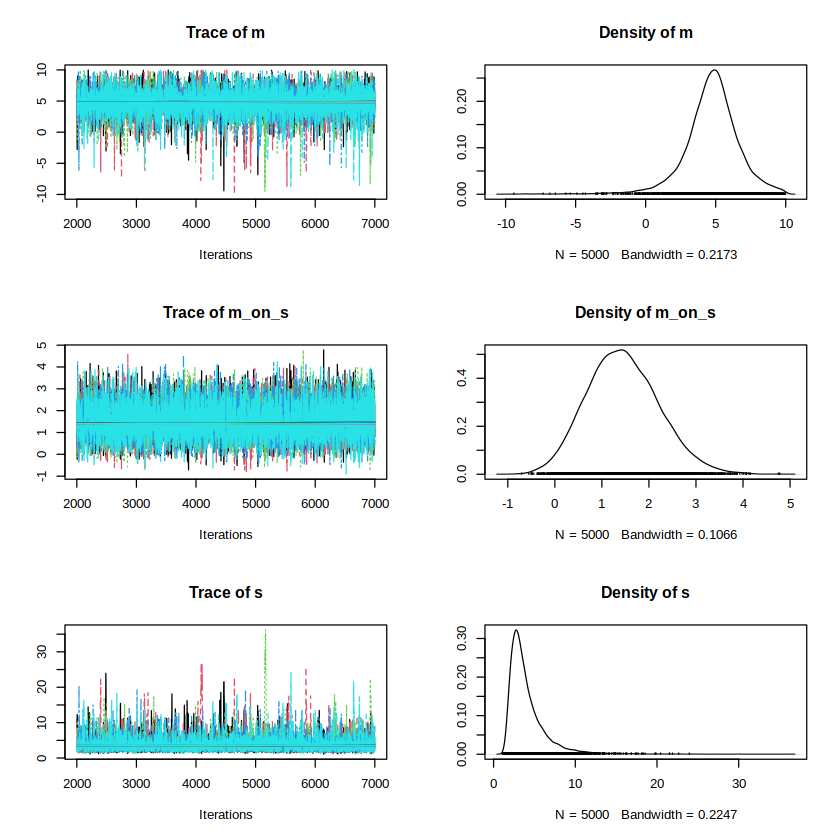

In [20]:
x = c(2.06, 5.56, 7.93, 6.56, 2.05)
data = list(x=x, N=length(x))

#jags dnorm() requires precision (tau) that is 1/s^2
model_text = "model {
    for (i in 1:N) {
        x[i] ~ dnorm(m, tau)
    }
    m ~ dunif(-10, 10)
    s ~ dunif(0, 50)
    tau = pow(s, -2)
    m_on_s = m/s
}"

inits = function() {
    list(m=runif(1, -10, 10), s=runif(1, 0, 50))
}

model = jags.model(textConnection(model_text), data, inits, 5)
update(model, 1000) #burn-in

samples = coda.samples(model, c("m", "s", "m_on_s"), 5000)
summary(samples)
plot(samples)

### Exercise 4

The data set that Edwin Hubble ised to show that galaxies are moving  either away or towards us are given in the following table:

$$
\begin{array}{c|cccccccccc}
D & 0.0032 & 0.0034 & 0.214 & 0.263 & 0.275 & 0.275 & 0.45 & 0.5 & 0.5 & 0.63 & 0.8 & 0.9 & 0.9 & 0.9 & 0.9 & 2 & 2 & 2 & 2\\
V & 170 & 290 & -130 & -70 & -185 & -220 & 200 & -290 & 270 & 200 & 920 & 450 & 500 & 500 & 960 & 500 & 850 & 800 & 1090\\
\end{array}
$$

a) Using this data set define a JAGS model to fit data with the following:

$V[i] \sim dnorm(b * D[i], c)$

Where V represent the velocity in units of km/s, D is the observed distance (in units of parsec) and b and c two parameters of the model.
Assume whatever prior distribution you think is appropriate.

In [22]:
D = c(0.0032, 0.0034, 0.214, 0.263, 0.275, 0.275, 0.45, 0.5, 0.5, 0.63, 0.8, 0.9, 0.9, 0.9, 0.9, 2, 2, 2, 2)
V = c(170, 290, -130, -70, -185, -220, 200, -290, 270, 200, 920, 450, 500, 500, 960, 500, 850, 800, 1090)
data = list(D=D, V=V, N=length(D))

#we have no infos on priors, so we set them as generic as possible
model_text = "model {
    for (i in 1:N) {
        V[i] ~ dnorm(b * D[i], c)
    }
    b ~ dnorm(0, 0.001)
    c ~ dgamma(0.001, 0.001)
}"

inits = function() {
    list(b=rnorm(1,0,1), c=rgamma(0.001, 0.001))
}

model = jags.model(textConnection(model_text), data, inits, 5)
update(model, 5000)
samples = coda.samples(model, c("b", "c"), 1000)

summary(samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 19
   Unobserved stochastic nodes: 2
   Total graph size: 54

Initializing model




Iterations = 5001:6000
Thinning interval = 1 
Number of chains = 5 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
b 3.260e+01 3.252e+01 4.599e-01      5.194e-01
c 3.747e-06 1.305e-06 1.846e-08      2.067e-08

2. Quantiles for each variable:

        2.5%       25%       50%       75%     97.5%
b -3.175e+01 1.067e+01 3.247e+01 5.483e+01 9.714e+01
c  1.648e-06 2.794e-06 3.612e-06 4.479e-06 6.713e-06


b) Plot the evolution of the chains, the posterior distribution of the parameters and the 95% credibility interval.

           2.5%        97.5%
b -3.175221e+01 9.713752e+01
c  1.647914e-06 6.713286e-06


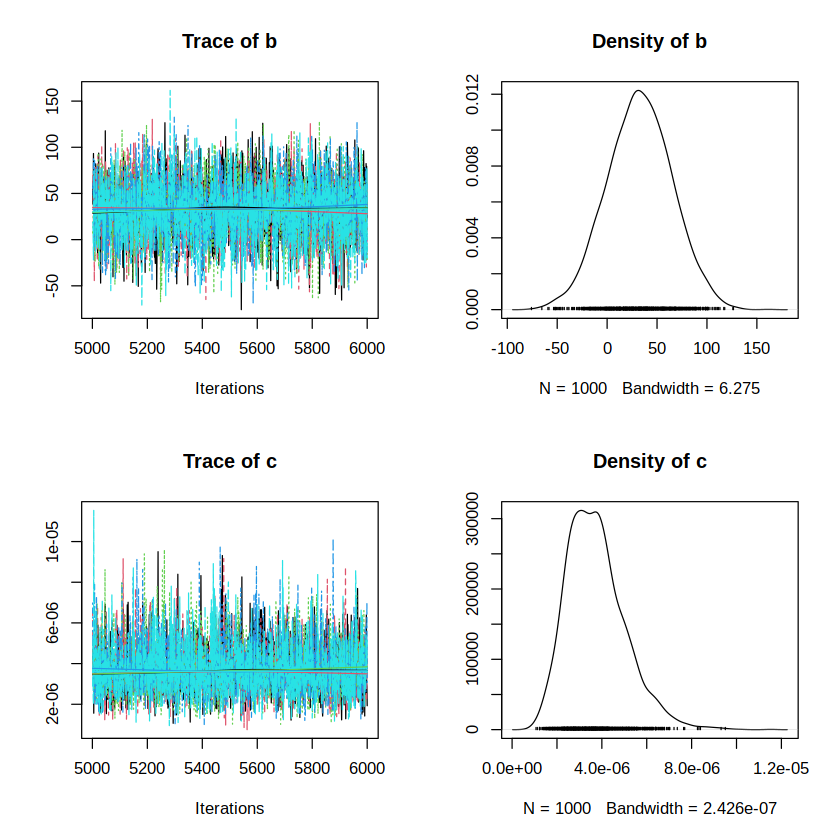

In [27]:
plot(samples)

ci = t(apply(as.mcmc(do.call(rbind, samples)), 2, function(x) quantile(x, c(0.025, 0.975))))
print(ci)